# Graph analysis (Francisco)

# Imports

In [ ]:
import pandas as pd
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt



# Load Data

In [ ]:
data = pd.read_csv(r"C:\Users\franc\Desktop\Francisco\DTU\Social Graphs\Final_project\archive\IMDb_All_Genres_etf_clean1.csv")

In [ ]:
data.head()

Movie_Title  Year           Director  \
0                                        Kantara  2022      Rishab Shetty   
1                                The Dark Knight  2008  Christopher Nolan   
2  The Lord of the Rings: The Return of the King  2003      Peter Jackson   
3                                      Inception  2010  Christopher Nolan   
4          The Lord of the Rings: The Two Towers  2002      Peter Jackson   

                                              Actors  Rating  Runtime(Mins)  \
0  Rishab Shetty, Sapthami Gowda, Kishore Kumar G...     9.3            148   
1  Christian Bale, Heath Ledger, Aaron Eckhart, M...     9.0            152   
2  Elijah Wood, Viggo Mortensen, Ian McKellen, Or...     9.0            201   
3  Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...     8.8            148   
4  Elijah Wood, Ian McKellen, Viggo Mortensen, Or...     8.8            179   

  Censor   Total_Gross main_genre           side_genre  
0     UA  Gross Unkown     Action    Adventure,  Drama  
1     UA      $534.86M     Action        Crime,  Drama  
2      U      $377.85M     Action    Adventure,  Drama  
3     UA      $292.58M     Action   Adventure,  Sci-Fi  
4     UA      $342.55M     Action    Adventure,  Drama

In [ ]:
print(f"Total movies: {len(data)}")

Total movies: 5562


In [ ]:
data.isna().sum()

Movie_Title      0
Year             0
Director         0
Actors           0
Rating           0
Runtime(Mins)    0
Censor           0
Total_Gross      0
main_genre       0
side_genre       0
dtype: int64

In [ ]:
data = data.drop_duplicates()

In [ ]:
print(f"Total movies: {len(data)}")

Total movies: 5554


## Graph Construction

In this project, we will create two graphs using the information in our dataset. Each graph represents a different perspective on the relationships between movies and actors.

### 1. Actor Graph

In this graph:

- Nodes: actors
- Edges: a connection between two actors who appear in the same movie
- Edge attributes:
  - movie title
  - year
  - genre
  - rating
  - director

This graph helps us analyze collaboration patterns between actors, identify central actors.

### 2. Movie Graph

In this graph:

- Nodes: movies
- Edges: a connection between two movies that share at least one actor
- Edge attributes:
  - names of shared actors
- Node attributes:
  - genre
  - rating

This graph allows us to explore relationships between movies based on shared cast members and identify clusters or groups of related films.

### Actor Graph

In [ ]:
G_actors = nx.Graph()

# Iterate through each movie
for _, row in data.iterrows():
    
    movie_title = row["Movie_Title"]
    year = row["Year"]
    director = row["Director"]
    rating = row["Rating"]
    genre = row["main_genre"]   # usando main_genre como o género principal
    
    # Split actors by comma
    actors = [a.strip() for a in row["Actors"].split(",")]
    
    # Add edges between every pair of actors in the movie
    for i in range(len(actors)):
        for j in range(i + 1, len(actors)):
            
            actor1 = actors[i]
            actor2 = actors[j]
            
            # Add the edge with movie attributes
            G_actors.add_edge(
                actor1,
                actor2,
                movie_title=movie_title,
                year=year,
                genre=genre,
                rating=rating,
                director=director
            )

print(f"Number of actors (nodes): {G_actors.number_of_nodes()}")
print(f"Number of collaborations (edges): {G_actors.number_of_edges()}")


Number of actors (nodes): 8430
Number of collaborations (edges): 31573


In [ ]:
isolated_nodes = list(nx.isolates(G_actors))
print(f"Number of isolated nodes: {len(isolated_nodes)}")

Number of isolated nodes: 0


In [ ]:
degree_dict = dict(G_actors.degree())
top_5 = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 most connected actors:")
for actor, degree in top_5:
    print(f"{actor}: {degree}")


Top 5 most connected actors:
Robert De Niro: 154
Tom Hanks: 139
Samuel L. Jackson: 132
Nicolas Cage: 132
Mark Wahlberg: 119


The actors, above printed, have the highest number of connections in the Actor Graph, meaning they have co-starred with many other actors

In [ ]:
avg_degree = sum(degree_dict.values()) / len(degree_dict)
print(f"Average degree: {avg_degree:.2f}")

Average degree: 7.49


The Actor Graph shows a moderate level of connectivity, with an average degree of 7.49

This means that, on average, each actor in the graph has co-starred with about 7 to 8 other actors.

In [ ]:
if nx.is_connected(G_actors):
    avg_path_length = nx.average_shortest_path_length(G_actors)
else:
    # Extract the largest connected component
    largest_cc = G_actors.subgraph(max(nx.connected_components(G_actors), key=len))
    avg_path_length = nx.average_shortest_path_length(largest_cc)

print(f"Average shortest path length: {avg_path_length:.3f}")


Average shortest path length: 4.443


This means that, on average, any actor can be reached from another actor through about 4 to 5 connections in the network of co-appearances.
The relatively short path length indicates that the actor network is fairly well connected.

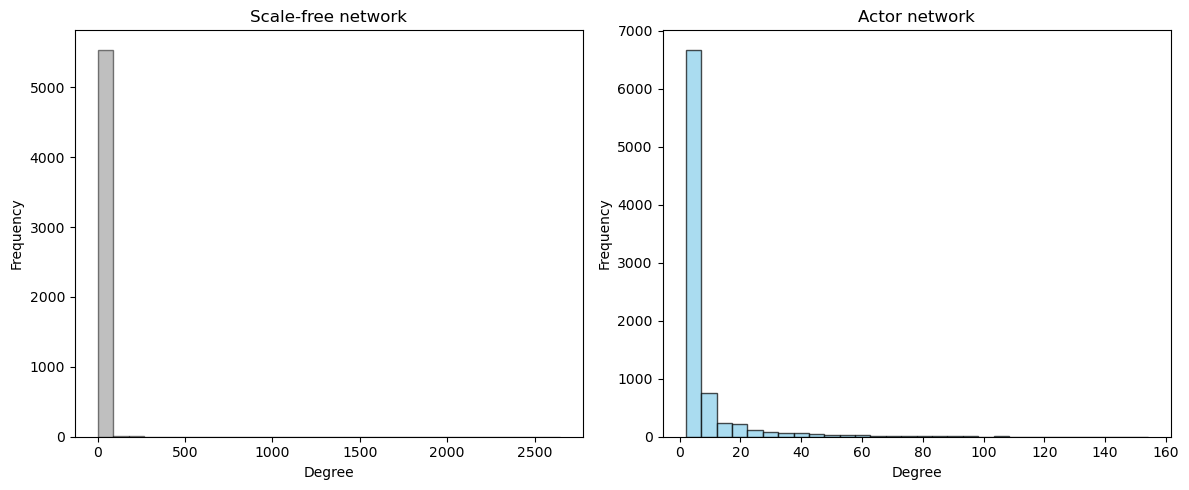

In [ ]:
d =[d for n,d in G_actors.degree()]

#create a "scale-free" graph
G_sf = nx.scale_free_graph(len(data))
#create a list with all the degrees in the scale-free network
sf_degrees = [d for n, d in G_sf.degree()]


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(sf_degrees, bins=30, alpha=0.5, label="Scale-free network", color='gray', edgecolor='black')
plt.title("Scale-free network")
plt.xlabel("Degree")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(d, bins=30, alpha=0.7, label="Actor network", color='skyblue', edgecolor='black')
plt.title("Actor network")
plt.xlabel("Degree")
plt.ylabel("Frequency")



plt.tight_layout()
plt.show()

The degree distribution of the Actor Graph shows characteristics of a scale-free network. Most actors have collaborated with only a small number of other actors, while a few actors serve as major hubs who have worked with many different colleagues. This long-tailed structure suggests that actor collaborations are not evenly distributed, but instead follow a preferential attachment pattern, where popular actors tend to collaborate even more, reinforcing their central role in the network.

In [ ]:
#Degree centrality
deg_cent = nx.degree_centrality(G_actors)

# Top 3
top3 = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:3]
print("Top 3 degree centrality:")
for node, cent in top3:
    print(f"{node}: {cent:.4f}")

# Bottom 3
bottom3 = sorted(deg_cent.items(), key=lambda x: x[1])[:3]
print("\nBottom 3 degree centrality:")
for node, cent in bottom3:
    print(f"{node}: {cent:.4f}")
    
average_centrality = round(np.mean(list(deg_cent.values())),4)
print("\nAverage degree centrality:", average_centrality)


Top 3 degree centrality:
Robert De Niro: 0.0183
Tom Hanks: 0.0165
Samuel L. Jackson: 0.0157

Bottom 3 degree centrality:
Laith Nakli: 0.0002
Martin Compston: 0.0002
Maria Thelma Smáradóttir: 0.0002

Average degree centrality: 0.0009


The centrality is a metric that mesures the node (actor) influency in a network. The bigger the value the more influent a node is. In this cenario we can comclude the node like the "Robert De Niro" and "Tom Hanks" are more central since the average centrality is 0.0009. 
On the other hand nodes like "Martin Compston" and "Maria Thelma Smáradóttir" are not so influent since their centrality is much bellow the average.

In [ ]:
#Betweenness centrality
bet_cent = nx.betweenness_centrality(G_actors)
# Top 3
top3 = sorted(bet_cent.items(), key=lambda x: x[1], reverse=True)[:3]
print("Top 3 betweenness:")
for node, cent in top3:
    print(f"{node}: {cent:.4f}")


Top 3 betweenness:
Irrfan Khan: 0.0279
Tom Hanks: 0.0257
Robert De Niro: 0.0188


The betweenness centrality is a metric that measures how frequently a node (actor) appears on the shortest path between other nodes in the graph. In this graph, the nodes with the highest values are "Irrfan Khan", "Tom Hanks" and "Robert De Niro". This means these actors,compered to the others, have a strong influence on the flow of connection between other actors.

In [ ]:
#Closeness centrality
clos_cent = nx.closeness_centrality(G_actors)
# Top 3
top3 = sorted(clos_cent.items(), key=lambda x: x[1], reverse=True)[:3]
print("Top 3 Closeness centrality:")
for node, cent in top3:
    print(f"{node}: {cent:.4f}")

Top 3 Closeness centrality:
Robert De Niro: 0.2863
Morgan Freeman: 0.2790
Julianne Moore: 0.2786


The closeness centrality is a metric that measures how quickly a node can reach all other nodes in the network.
Nodes with higher values can access or influence others more efficiently, as they are positioned closer (in terms of path length) to most nodes in the graph.
In this scenario, the actors "Robert De Niro" (0.2863), "Morgan Freeman" (0.2790), and "Julianne Moore" (0.2786) show the highest closeness centrality values.
This indicates that these actors occupy central and well-connected positions, allowing them to interact or co-star with a wide variety of other actors through short connection paths.
Consequently, they can be seen as key connectors in the network, facilitating communication or collaboration between different groups of actors.

In [ ]:
#Eigenvector centrality
eig_cent = nx.eigenvector_centrality(G_actors)
# Top 3
top3 = sorted(eig_cent.items(), key=lambda x: x[1], reverse=True)[:3]
print("Top 3 Eigenvector centrality:")
for node, cent in top3:
    print(f"{node}: {cent:.4f}")

Top 3 Eigenvector centrality:
Robert De Niro: 0.1308
Matt Damon: 0.1084
Mark Wahlberg: 0.1082


The eigenvector centrality is a metric that measures not only how many connections a node has, but also how important or influential its connections are.
In other words, a node connected to other highly connected nodes will have a higher eigenvector centrality value.
In this scenario, the actors Robert De Niro (0.1308), Matt Damon (0.1084), and Mark Wahlberg (0.1082) have the highest eigenvector centrality scores.
This suggests that these actors are not only well-connected themselves, but they are also connected to other highly influential actors, placing them at the very core of the network’s structure.
Therefore, they can be considered as central figures of influence within the actor collaboration network, forming strong links with other key players in the film industry.

In [ ]:
#PageRank 
pr = nx.pagerank(G_actors)
# Top 3
top3 = sorted(pr.items(), key=lambda x: x[1], reverse=True)[:3]
print("Top 3 PageRank:")
for node, cent in top3:
    print(f"{node}: {cent:.4f}")

Top 3 PageRank:
Tom Hanks: 0.0016
Robert De Niro: 0.0016
Nicolas Cage: 0.0014


The eigenvector centrality is a metric that measures not only how many connections a node has, but also how important or influential its connections are.
In this graph, the actors Tom Hanks (0.0016), Robert De Niro (0.0016), and Nicolas Cage (0.0014) present the highest eigenvector centrality values.
However, the overall values are quite low, which indicates that the network is highly dispersed, and no single actor holds a dominant or strongly influential position.

# Movie Graph

In [ ]:
G_movies = nx.Graph()

# Add movies as nodes with attributes
for _, row in data.iterrows():
    movie_title = row["Movie_Title"]
    genre = row["main_genre"]  
    rating = row["Rating"]
    
    G_movies.add_node(movie_title, genre=genre, rating=rating)

# Build edges based on shared actors
# Create a dictionary: actor -> list of movies they appear in
actor_movies = {}

for _, row in data.iterrows():
    movie_title = row["Movie_Title"]
    actors = [a.strip() for a in row["Actors"].split(",")]
    
    for actor in actors:
        if actor not in actor_movies:
            actor_movies[actor] = []
        actor_movies[actor].append(movie_title)

# For each actor, connect all movies they appear in
for actor, movies in actor_movies.items():
    for m1, m2 in combinations(movies, 2):
        if G_movies.has_edge(m1, m2):
            G_movies[m1][m2]["shared_actors"].append(actor)
        else:
            G_movies.add_edge(m1, m2, shared_actors=[actor])


print(f"Number of movie nodes: {G_movies.number_of_nodes()}")
print(f"Number of edges (shared cast links): {G_movies.number_of_edges()}")

isolated = list(nx.isolates(G_movies))
print(f"Isolated movies: {len(isolated)}")


Number of movie nodes: 5453
Number of edges (shared cast links): 95125
Isolated movies: 233


## Degree analysis  
Movies with the most shared actors (highest degree)

In [ ]:
degree_movies = dict(G_movies.degree())
top_5_movies = sorted(degree_movies.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 connected movies:")
for movie, deg in top_5_movies:
    print(f"{movie}: {deg}")

avg_movie_degree = sum(degree_movies.values()) / len(degree_movies)
print(f"\nAverage movie degree: {avg_movie_degree:.2f}")


Top 5 connected movies:
Les Misérables: 164
The Good Shepherd: 148
The Italian Job: 138
Last Vegas: 134
Heist: 131

Average movie degree: 34.89


The Movie Graph shows a relatively high level of connectivity, with an average degree of 34.89, meaning each movie is linked to many others through shared actors. The top connected films, such as Les Misérables, The Good Shepherd, and The Italian Job, serve as major hubs in the network, indicating that they feature large or diverse casts that strongly link different parts of the movie network.

## Average shortest path length  


In [ ]:
if nx.is_connected(G_movies):
    avg_path_movies = nx.average_shortest_path_length(G_movies)
else:
    largest_cc_movies = G_movies.subgraph(max(nx.connected_components(G_movies), key=len))
    avg_path_movies = nx.average_shortest_path_length(largest_cc_movies)

print(f"Average shortest path length (movies): {avg_path_movies:.3f}")


Average shortest path length (movies): 3.217


The Movie Graph has an average shortest path length of 3.217, meaning that, on average, any movie can be reached from another in just over three steps via shared actors. This relatively small path length indicates that the network is fairly well connected, and that even movies that do not share actors directly are still only a few connections away from one another.

## Degree distribution comparison  
Movie graph vs Scale-free synthetic graph


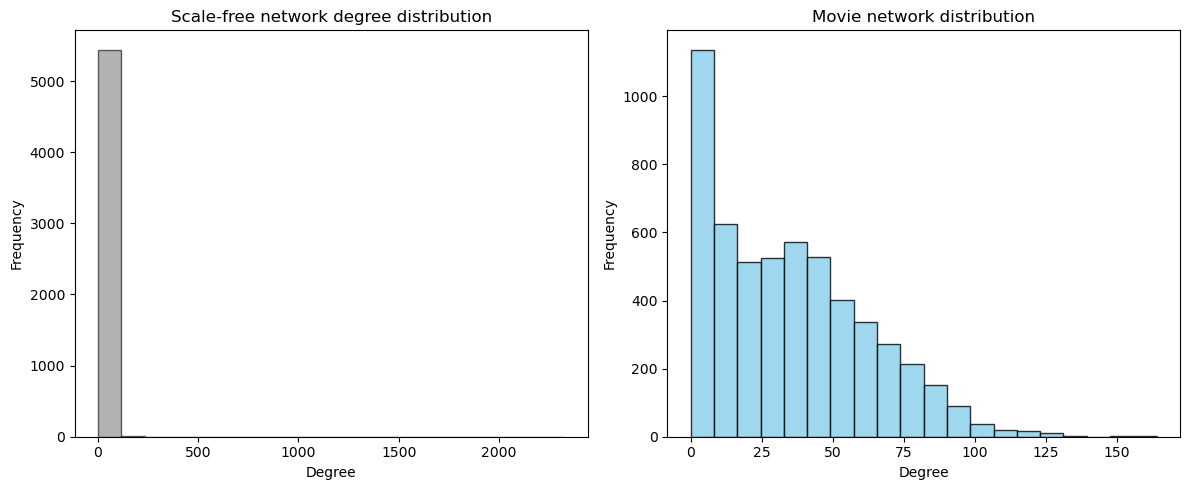

In [ ]:
movie_degrees = [d for _, d in G_movies.degree()]

G_sf2 = nx.scale_free_graph(len(G_movies))
sf2_degrees = [d for _, d in G_sf2.degree()]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(sf2_degrees, bins=20, alpha=0.6, color='gray', edgecolor='black')
plt.title("Scale-free network degree distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(movie_degrees, bins=20, alpha=0.8, color='skyblue', edgecolor='black')
plt.title("Movie network distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


The degree distribution of the Movie Graph shows a clear similarity to that of a scale-free network. Both distributions have a long tail, where most nodes have low degree while a few nodes act as hubs with very high degree. This indicates that the movie network exhibits scale-free behavior, meaning that a small number of movies connect to many others through shared actors.

## Degree centrality of movies  


In [ ]:
deg_cent_movies = nx.degree_centrality(G_movies)

top3_deg = sorted(deg_cent_movies.items(), key=lambda x: x[1], reverse=True)[:3]
bottom3_deg = sorted(deg_cent_movies.items(), key=lambda x: x[1])[:3]

print("Top 3 degree centrality:")
for movie, val in top3_deg:
    print(f"{movie}: {val:.4f}")

print("\nBottom 3 degree centrality:")
for movie, val in bottom3_deg:
    print(f"{movie}: {val:.4f}")

avg_deg_cent = np.mean(list(deg_cent_movies.values()))
print(f"\nAverage degree centrality: {avg_deg_cent:.4f}")


Top 3 degree centrality:
Les Misérables: 0.0301
The Good Shepherd: 0.0271
The Italian Job: 0.0253

Bottom 3 degree centrality:
Dag II: 0.0000
Kimetsu no Yaiba: Mugen Ressha-Hen: 0.0000
Karthikeya 2: 0.0000

Average degree centrality: 0.0064


Although the numerical values of degree centrality are small, this is expected because the Movie Graph contains a very large number of nodes. In a network of this size, even highly connected movies represent only a small fraction of the total. The results still clearly identify the most central films: Les Misérables, The Good Shepherd, and The Italian Job reach over 3% of all movies directly through shared actors, which makes them major hubs in the network. On the other end of the spectrum, several movies show a centrality of zero, meaning they do not share actors with any other film. Overall, the metric works as intended and successfully highlights the most and least connected movies.

## 6. Betweenness centrality  
Movies acting as bridges between cast-sharing clusters


In [ ]:
bet_cent_movies = nx.betweenness_centrality(G_movies)

top3_bet = sorted(bet_cent_movies.items(), key=lambda x: x[1], reverse=True)[:3]
print("Top 3 betweenness centrality:")
for movie, val in top3_bet:
    print(f"{movie}: {val:.4f}")


Top 3 betweenness centrality:
War: 0.0102
Inferno: 0.0100
Bend It Like Beckham: 0.0074


The ranking highlights a small group of movies that act as important intermediaries connecting different parts of the network. War, Inferno, and Bend It Like Beckham have the highest betweenness scores, meaning they lie on a relatively large number of shortest paths between other movies.

## Closeness centrality  
Movies closest to all others in the graph


In [ ]:
clos_cent_movies = nx.closeness_centrality(G_movies)

top3_clos = sorted(clos_cent_movies.items(), key=lambda x: x[1], reverse=True)[:3]
print("Top 3 closeness centrality:")
for movie, v in top3_clos:
    print(f"{movie}: {v:.4f}")


Top 3 closeness centrality:
The Good Shepherd: 0.3721
Les Misérables: 0.3711
The Italian Job: 0.3677


The closeness centrality results show that The Good Shepherd, Les Misérables, and The Italian Job are the movies that, on average, have the shortest distances to all other films in the network. Their relatively high closeness values indicate that they are positioned near the “center” of the Movie Graph, allowing them to reach other movies through only a small number of steps via shared actors. This suggests that these films are highly integrated into the overall structure of the network and play a key role in keeping the graph well-connected.

## Eigenvector centrality  
Movies connected to highly connected movies


In [ ]:
eig_cent_movies = nx.eigenvector_centrality(G_movies)

top3_eig = sorted(eig_cent_movies.items(), key=lambda x: x[1], reverse=True)[:3]
print("Top 3 eigenvector centrality:")
for movie, v in top3_eig:
    print(f"{movie}: {v:.4f}")


Top 3 eigenvector centrality:
The Good Shepherd: 0.1136
Marvin's Room: 0.1050
Last Vegas: 0.1034


## PageRank  
Rank of movies based on connections and importance


In [ ]:
pr_movies = nx.pagerank(G_movies)

top3_pr = sorted(pr_movies.items(), key=lambda x: x[1], reverse=True)[:3]
print("Top 3 PageRank movies:")
for movie, v in top3_pr:
    print(f"{movie}: {v:.4f}")


Top 3 PageRank movies:
Les Misérables: 0.0007
Murder on the Orient Express: 0.0006
The Good Shepherd: 0.0005


### Degree assortativity  



In [ ]:
deg_assort = nx.degree_assortativity_coefficient(G_movies)
print(f"Degree assortativity coefficient: {deg_assort:.4f}")


Degree assortativity coefficient: 0.3449


The Movie Graph has a degree assortativity coefficient of 0.3449, indicating a moderate tendency for movies with a similar number of connections to link with each other. In other words, highly connected movies tend to be connected to other highly connected movies, while less connected movies are more likely to link with other low-degree movies. This positive assortativity suggests a tendency for clustering among popular films with large or diverse casts, reinforcing the presence of hubs and local communities within the network.

Attribute assortativity by main_genre  
Compute attribute assortativity using the 'main_genre' node attribute (do movies preferentially connect to movies of the same genre?).


In [ ]:
genre_assortativity = nx.attribute_assortativity_coefficient(G_movies, "genre")

print(f"Genre assortativity coefficient: {genre_assortativity:.4f}")


Genre assortativity coefficient: 0.0921


The Movie Graph shows a main_genre assortativity coefficient of 0.0921, which is slightly positive. This indicates a weak tendency for movies to connect with other films of the same main_genre through shared actors. In other words, while there is a small preference for genre-based connections, most movies are linked to films across different main_genre. This suggests that actors often work in multiple genres, creating bridges between otherwise distinct types of movies in the network.

# Linguistic analysis (Kelvin)

### imports

In [1]:
import pandas as pd
import networkx as nx
from networkx.algorithms import community
from itertools import combinations
import requests
import time
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt

### Data Handling

### Load the Data

>#### 1. txt files

In [2]:
import os, re, pandas as pd

CSV_PATH    = r"Data\IMDb_All_Genres_etf_clean1.csv"
SCRIPTS_DIR = r"Data\movie scripts\raw_texts"
TITLE_COL   = "Movie_Title"   # CSV movie title column name
SCRIPT_COL = "script_text"    # column name where the scripts are stored
# your cleaning function (or use your own)
def clean_title(fn):
    base = os.path.splitext(os.path.basename(fn))[0]
    return re.sub(r"_\d+$", "", base).strip()

# --- 1) Load scripts into a dict {clean_title: script_text} ---
script_dict = {}
for f in os.listdir(SCRIPTS_DIR):
    if f.lower().endswith(".txt"):
        title = clean_title(f).lower()
        with open(os.path.join(SCRIPTS_DIR, f), encoding="utf-8", errors="ignore") as fh:
            script_dict[title] = fh.read()

# --- 2) Load CSV and attach scripts ---
df = pd.read_csv(CSV_PATH)
df[SCRIPT_COL] = df[TITLE_COL].astype(str).str.lower().map(script_dict)

# --- 3) Save ---
df.to_csv(CSV_PATH, index=False)

print(f"Added script text to {df[SCRIPT_COL].notna().sum()} movies (out of {len(df)})")




Added script text to 1542 movies (out of 5562)


>#### JSON data

In [3]:
import re, json, pandas as pd

# === paths + columns (adjust if needed) ===
JSON_PATH  = r"Data\movie scripts\movies.json"

# 1) load CSV
df = pd.read_csv(CSV_PATH)

# ensure script column exists
if SCRIPT_COL not in df.columns:
    df[SCRIPT_COL] = pd.NA

# also treat empty strings as missing
df[SCRIPT_COL] = df[SCRIPT_COL].replace("", pd.NA)

# normalise titles (collapse whitespace etc.)
df[TITLE_COL] = (
    df[TITLE_COL]
    .astype(str)
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)
)

# 2) load JSON and build {cleaned_lower_title: script}
with open(JSON_PATH, encoding="utf-8") as f:
    data = json.load(f)
json_dict = {
    re.sub(r"\s+", " ", item["Name"]).strip().lower(): item["Script"]
    for item in data
}

# 3) fill ONLY missing scripts from JSON
missing_mask = df[SCRIPT_COL].isna()
filled = df.loc[missing_mask, TITLE_COL].str.lower().map(json_dict)

newly_filled_mask = missing_mask & filled.notna()
df.loc[newly_filled_mask, SCRIPT_COL] = filled[newly_filled_mask]

# 4) save
df.to_csv(CSV_PATH, index=False)

print(f"✅ Filled {newly_filled_mask.sum()} scripts from JSON and saved to {CSV_PATH}.")


✅ Filled 119 scripts from JSON and saved to Data\IMDb_All_Genres_etf_clean1.csv.


>#### 3. Parquet data

In [4]:
import pandas as pd

# === paths ===
PARQUET_PATH = r"Data\movie scripts\movie_scripts.parquet"   # update if needed

# 1) load parquet, keep only relevant columns
df_parq = pd.read_parquet(PARQUET_PATH)[["Movie", "Script"]]

# normalize
df_parq["Movie"] = (
    df_parq["Movie"].astype(str)
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)
    .str.lower()
)
df_parq["Script"] = df_parq["Script"].astype(str)

# 2) make mapping {movie_title: script_text}
parquet_dict = dict(zip(df_parq["Movie"], df_parq["Script"]))

# 3) load CSV and normalise titles
df = pd.read_csv(CSV_PATH)
if SCRIPT_COL not in df.columns:
    df[SCRIPT_COL] = pd.NA
df[SCRIPT_COL] = df[SCRIPT_COL].replace("", pd.NA)
df[TITLE_COL] = (
    df[TITLE_COL]
    .astype(str)
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)
    .str.lower()
)

# 4) fill missing scripts from parquet
missing_mask = df[SCRIPT_COL].isna()
filled = df.loc[missing_mask, TITLE_COL].map(parquet_dict)
df.loc[missing_mask & filled.notna(), SCRIPT_COL] = filled.dropna()

# 5) save
df.to_csv(CSV_PATH, index=False)
print(f"✅ Added {filled.notna().sum()} scripts from Parquet file and saved to {CSV_PATH}.")


✅ Added 14 scripts from Parquet file and saved to Data\IMDb_All_Genres_etf_clean1.csv.


### --------------------------------

### building the graph

>#### Build a map between a movie node and actors

In [5]:
# --- 2. Build a mapping: movie_node -> list of actors ---
def parse_actors(actor_str):
    if pd.isna(actor_str):
        return []
    # Split on comma and strip spaces
    return [a.strip() for a in str(actor_str).split(",") if a.strip()]

movie_to_actors = {}

for _, row in df.iterrows():
    title = str(row["Movie_Title"]).strip()
    year = int(row["Year"]) if not pd.isna(row["Year"]) else None
    
    # Use "Title (Year)" as node label (fallback to just title if year missing)
    if year:
        movie_node = f"{title} ({year})"
    else:
        movie_node = title

    actors = parse_actors(row["Actors"])
    if actors:  # only include movies with at least one actor
        movie_to_actors[movie_node] = actors


>#### Build an actors -> movie map

In [6]:

# --- 3. Build actor -> movies index ---
actor_to_movies = {}
for movie, actors in movie_to_actors.items():
    for actor in actors:
        actor_to_movies.setdefault(actor, set()).add(movie)



>#### create the graph G

In [7]:
# --- 4. Create graph: movie–movie edges via shared actors ---
G = nx.Graph()

# add all movies as nodes
G.add_nodes_from(movie_to_actors.keys())

# for each actor, connect all pairs of movies they appear in
for actor, movies in actor_to_movies.items():
    if len(movies) < 2:
        continue  # no edges if actor is only in one movie
    for m1, m2 in combinations(movies, 2):
        if G.has_edge(m1, m2):
            G[m1][m2]["weight"] += 1
            G[m1][m2]["actors"].add(actor)
        else:
            # store both weight and which actors create this link
            G.add_edge(m1, m2, weight=1, actors={actor})

# Convert actor sets to sorted lists for nicer inspection
for u, v, data in G.edges(data=True):
    data["actors"] = sorted(data["actors"])

>#### Add metadata to the movie nodes

In [8]:
for _, row in df.iterrows():
    title = str(row["Movie_Title"]).strip()
    year = int(row["Year"]) if not pd.isna(row["Year"]) else None
    node_name = f"{title} ({year})" if year else title

    if node_name in G:
        G.nodes[node_name]["year"] = year
        G.nodes[node_name]["director"] = row.get("Director", None)
        G.nodes[node_name]["rating"] = row.get("Rating", None)
        G.nodes[node_name]["runtime"] = row.get("Runtime(Mins)", None)
        G.nodes[node_name]["censor"] = row.get("Censor", None)
        G.nodes[node_name]["total_gross"] = row.get("Total_Gross", None)
        G.nodes[node_name]["main_genre"] = row.get("main_genre", None)
        G.nodes[node_name]["side_genre"] = row.get("side_genre", None)
        G.nodes[node_name]["script_text"] = row.get("script_text", None)
        G.nodes[node_name]["has_script"] = row.get("has_script", None)

In [9]:
def has_script_true(attrs):
    v = attrs.get("has_script", False)
    if isinstance(v, str):
        return v.strip().lower() in {"true", "1", "yes", "y"}
    return bool(v)


nodes_with_script = [n for n, d in G.nodes(data=True) if has_script_true(d)]

H = G.subgraph(nodes_with_script).copy()
print(f"Script subgraph: {H.number_of_nodes()} nodes, {H.number_of_edges()} edges.")

Script subgraph: 1540 nodes, 12129 edges.


>#### Sanity check

In [10]:
print(f"Nodes (movies): {G.number_of_nodes()}")
print(f"Edges (shared actors): {G.number_of_edges()}")

print("")


Nodes (movies): 5551
Edges (shared actors): 95221



### Creating the Script graph

In [11]:
largest_cc_nodes = max(nx.connected_components(H), key=len)

H_lcc = H.subgraph(largest_cc_nodes).copy()

#### checking the graph size

In [12]:
print(f"Nodes (movies): {H_lcc.number_of_nodes()}")
print(f"Edges (shared actors): {H_lcc.number_of_edges()}")

Nodes (movies): 1459
Edges (shared actors): 12119


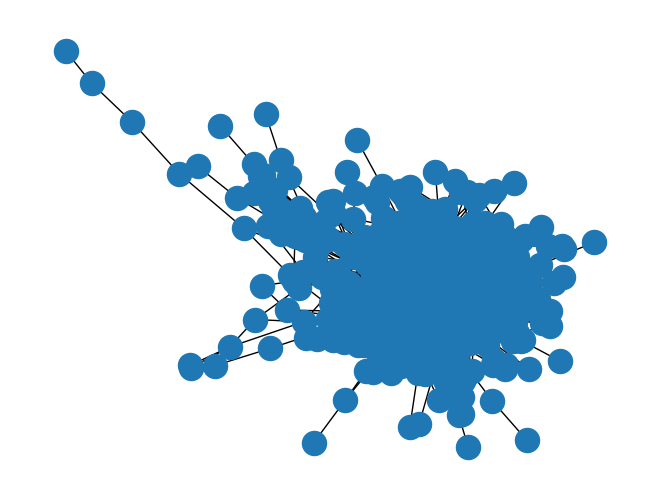

In [13]:
nx.draw(H_lcc)

### Checking graph stats

In [14]:
all_attrs = set()

for _, data in H_lcc.nodes(data=True):
    all_attrs.update(data.keys())

print(all_attrs)

{'has_script', 'total_gross', 'side_genre', 'script_text', 'censor', 'rating', 'director', 'year', 'main_genre', 'runtime'}


In [15]:
degrees = [deg for _, deg in H_lcc.degree()]
print("min:", np.min(degrees))
print("max:", np.max(degrees))
print("mean:", np.mean(degrees))
print("median:", np.median(degrees))

min: 1
max: 57
mean: 16.61274845784784
median: 15.0


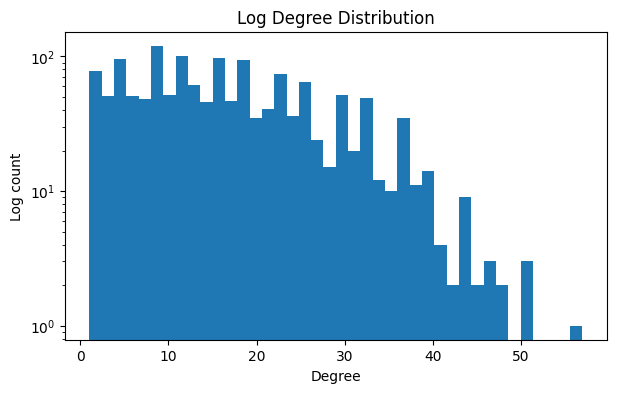

In [16]:
plt.figure(figsize=(7,4))
plt.hist(degrees, bins=40, log=True)
plt.xlabel("Degree")
plt.ylabel("Log count")
plt.title("Log Degree Distribution")
plt.show()

## Communities

>### Finding communities and plotting them

In [17]:
G_work = H_lcc

communities = list(community.louvain_communities(G_work,seed=42))
print(f"Found {len(communities)} communities")

# sizes
sizes = sorted([len(c) for c in communities], reverse=True)
for i, s in enumerate(sizes[:10]):
    print(f"Community {i}: {s} nodes")

Found 22 communities
Community 0: 125 nodes
Community 1: 103 nodes
Community 2: 99 nodes
Community 3: 95 nodes
Community 4: 93 nodes
Community 5: 84 nodes
Community 6: 77 nodes
Community 7: 77 nodes
Community 8: 74 nodes
Community 9: 71 nodes


In [18]:
comm_map = {}
for cid, comm in enumerate(communities):
    for node in comm:
        comm_map[node] = cid

nx.set_node_attributes(G_work, comm_map, "community")


#### plotting the communities

C:\Users\kelvi\AppData\Local\Temp\ipykernel_37064\3321268379.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")   # good for up to 20 communities


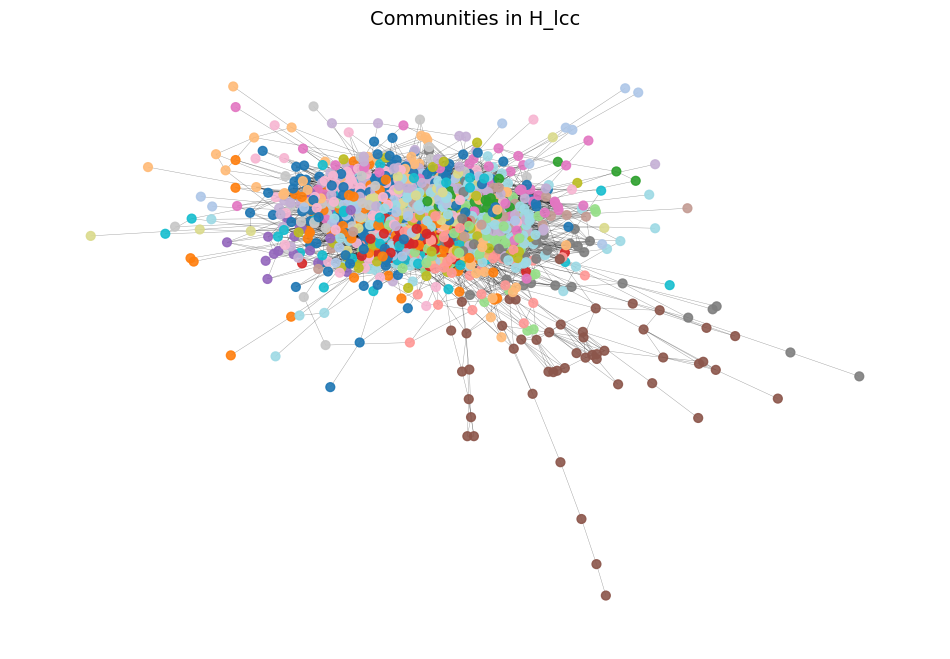

In [19]:
# 1) Extract community label for each node
communities = [H_lcc.nodes[n]["community"] for n in H_lcc.nodes()]

# 2) Choose a colour map
cmap = plt.cm.get_cmap("tab20")   # good for up to 20 communities

# 3) Compute layout (ForceAtlas2-like)
pos = nx.spring_layout(
    H_lcc,
    seed=42,
    k=0.15,       # spacing
    iterations=200
)

# 4) Draw
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(
    H_lcc,
    pos,
    node_color=communities,
    cmap=cmap,
    node_size=40,
    alpha=0.9
)
nx.draw_networkx_edges(
    H_lcc,
    pos,
    width=0.3,
    alpha=0.4
)

plt.axis("off")
plt.title("Communities in H_lcc", fontsize=14)
plt.show()


#### plot of genre and connectivity

C:\Users\kelvi\AppData\Local\Temp\ipykernel_37064\2989443602.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")  # up to ~20 distinct colours works well


(np.float64(-0.5017314969964899),
 np.float64(0.6167729095988643),
 np.float64(-1.1435619090457494),
 np.float64(0.5108181856719338))

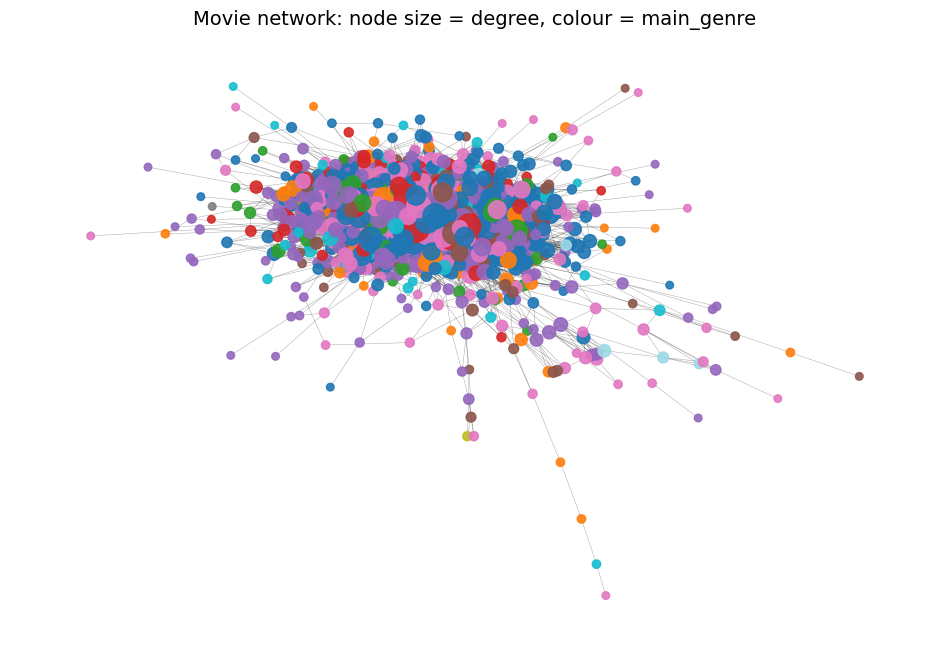

In [20]:
# ---- 1) Choose the working graph ----
G_plot = H_lcc   # just to have a short name

# ---- 2) Layout
try:
    pos  # if pos already exists, keep it
except NameError:
    pos = nx.spring_layout(
        G_plot,
        seed=42,
        k=0.15,
        iterations=200
    )

# ---- 3) Build colour mapping from main_genre ----
genres = []
for n, d in G_plot.nodes(data=True):
    g = d.get("main_genre", "Unknown")
    # guard against NaN / None
    if g is None or (isinstance(g, float) and np.isnan(g)):
        g = "Unknown"
    genres.append(g)

unique_genres = sorted(set(genres))
genre_to_id = {g: i for i, g in enumerate(unique_genres)}

node_colors = [genre_to_id[g] for g in genres]

cmap = plt.cm.get_cmap("tab20")  # up to ~20 distinct colours works well

# ---- 4) Node sizes = degree (connectivity)
deg_dict = dict(G_plot.degree())
deg_vals = np.array([deg_dict[n] for n in G_plot.nodes()])

# scale degrees to a reasonable size range
min_size = 30
max_size = 400
if deg_vals.max() == deg_vals.min():
    node_sizes = np.full_like(deg_vals, (min_size + max_size) / 2, dtype=float)
else:
    node_sizes = min_size + (deg_vals - deg_vals.min()) * (max_size - min_size) / (
        deg_vals.max() - deg_vals.min()
    )

# ---- 5) Draw the graph ----
plt.figure(figsize=(12, 8))

nodes = nx.draw_networkx_nodes(
    G_plot,
    pos,
    node_color=node_colors,
    cmap=cmap,
    node_size=node_sizes,
    alpha=0.9,
)
nx.draw_networkx_edges(
    G_plot,
    pos,
    width=0.3,
    alpha=0.4,
)

plt.title("Movie network: node size = degree, colour = main_genre", fontsize=14)
plt.axis("off")

>### Community analysis

### community overview

In [64]:
import pandas as pd

rows = []
for n, d in H_lcc.nodes(data=True):
    rows.append({
        "movie":       n,
        "community":   d.get("community"),
        "main_genre":  d.get("main_genre"),
        "rating":      d.get("rating"),
        "year":        d.get("year"),
        "script_text": d.get("script_text"),
        "side_genre":  d.get("side_genre"),
    })

df = pd.DataFrame(rows)
df.head()
# Size per community
sizes = df["community"].value_counts().sort_index()
print(sizes)


community
0      40
1     125
2      93
3      84
4      74
5      35
6      65
7      71
8      61
9      23
10     99
11     49
12     34
13     51
14    103
15     39
16     50
17     77
18     55
19     77
20     59
21     95
Name: count, dtype: int64


#### Top genres in each community

In [65]:
genre_summary = (
    df.groupby(["community", "main_genre"])
    .size()
    .reset_index(name="count")
    .sort_values(["community", "count"], ascending=[True, False])
)

# Show top 5 genres per community
top_genres = (
    genre_summary.groupby("community")
    .head(5)
    .reset_index(drop=True)
)

top_genres


community main_genre  count
0            0      Drama     10
1            0     Comedy      7
2            0     Action      6
3            0  Biography      4
4            0      Crime      4
..         ...        ...    ...
105         21     Comedy     24
106         21      Drama     21
107         21     Action     19
108         21      Crime     13
109         21  Biography      8

[110 rows x 3 columns]

In [66]:
top1_share = (
    df.groupby("community")["main_genre"]
    .agg(lambda x: x.value_counts(normalize=True).iloc[0])
)

print(top1_share)


community
0     0.250000
1     0.304000
2     0.247312
3     0.404762
4     0.310811
5     0.400000
6     0.276923
7     0.309859
8     0.426230
9     0.434783
10    0.262626
11    0.346939
12    0.470588
13    0.470588
14    0.291262
15    0.358974
16    0.360000
17    0.337662
18    0.254545
19    0.259740
20    0.389831
21    0.252632
Name: main_genre, dtype: float64


In [67]:
rating_summary = df.groupby("community")["rating"].agg(["count", "mean", "median"])
rating_summary.sort_values("mean", ascending=False)


count      mean  median
community                         
11            49  7.875510    7.90
8             61  7.195082    7.20
2             93  7.193548    7.20
18            55  7.192727    7.20
7             71  7.147887    7.20
15            39  7.107692    7.10
6             65  7.100000    7.20
20            59  7.081356    7.00
21            95  7.057895    7.10
0             40  7.050000    7.10
19            77  7.042857    7.10
4             74  7.035135    7.15
10            99  7.023232    7.10
3             84  7.021429    7.15
16            50  6.972000    6.90
14           103  6.912621    7.00
1            125  6.863200    6.90
12            34  6.847059    6.75
5             35  6.822857    6.80
17            77  6.758442    6.90
13            51  6.637255    6.60
9             23  6.326087    6.20

In [68]:
import networkx as nx

degree_dict = dict(H_lcc.degree())

df["degree"] = df["movie"].map(degree_dict)

top_hubs = (
    df.sort_values(["community", "degree"], ascending=[True, False])
    .groupby("community")
    .head(5)
    .reset_index(drop=True)
)

top_hubs[["community", "movie", "degree", "main_genre"]]


community                              movie  degree main_genre
0            0              public enemies (2009)      31     Action
1            0         edward scissorhands (1990)      27      Drama
2            0               donnie brasco (1997)      26  Biography
3            0          great expectations (1998)      26      Drama
4            0               reality bites (1994)      25     Comedy
..         ...                                ...     ...        ...
105         21                the departed (2006)      50      Crime
106         21               the big short (2015)      50  Biography
107         21          burn after reading (2008)      44     Comedy
108         21             the italian job (2003)      43     Action
109         21  the men who stare at goats (2009)      42     Comedy

[110 rows x 4 columns]

In [69]:
#df_scripts = df[df["has_script"] == True][["community", "script_text"]]
#df_scripts.head()


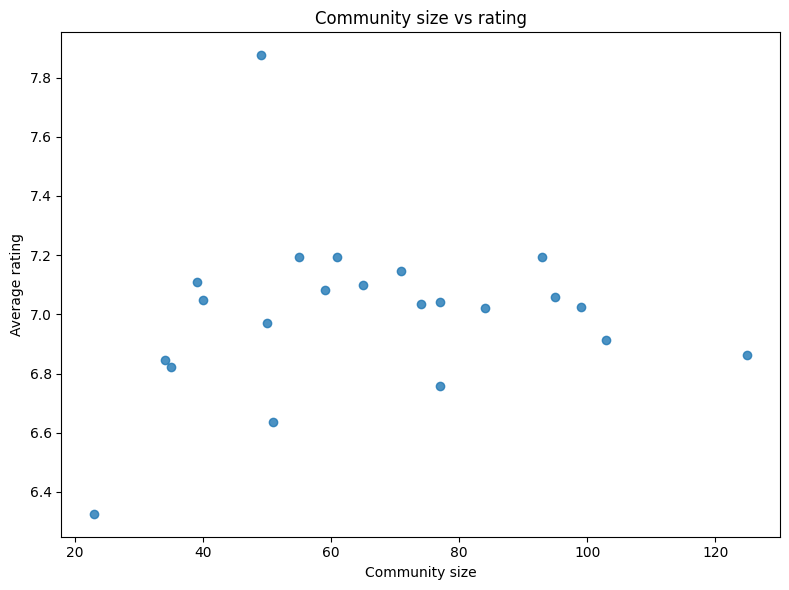

In [71]:

# Compute size and average rating of each community
summary = df.groupby("community").agg(
    community_size=("movie", "count"),
    avg_rating=("rating", "mean")
).reset_index()

# Create scatter plot (same style as your original)
plt.figure(figsize=(8, 6))
plt.scatter(summary["community_size"], summary["avg_rating"], alpha=0.8)

plt.title("Community size vs rating")
plt.xlabel("Community size")
plt.ylabel("Average rating")

plt.tight_layout()
plt.show()


>#### analysis 
The relationship between community size and average rating shows a weak negative trend: large communities tend to have average ratings close to the global mean, while several midsize communities achieve noticeably higher average ratings (~7.7–7.9). This suggests that widely connected, mainstream film clusters (e.g., action–comedy crossovers) receive more moderate reception, whereas smaller, more thematically or stylistically cohesive actor networks (e.g., tightly-linked drama or creative-driven communities) tend to contain higher-rated movies.

#### Top words in communities

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer

# small helper: map community -> combined script text
community_texts = (
    df.groupby("community")["script_text"]
      .apply(lambda x: "\n".join(str(t) for t in x if isinstance(t, str)))
)

vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words="english",
)

X = vectorizer.fit_transform(community_texts.values)
terms = vectorizer.get_feature_names_out()

# For each community: top 15 words by TF-IDF
top_words_per_comm = {}

import numpy as np

for idx, comm in enumerate(community_texts.index):
    row = X[idx].toarray().ravel()
    top_idx = row.argsort()[::-1][:15]
    top_terms = [(terms[i], row[i]) for i in top_idx]
    top_words_per_comm[comm] = top_terms

# Example: print for first few communities
for comm in sorted(top_words_per_comm.keys())[:]:
    print(f"\nCommunity {comm} — top words:")
    for word, score in top_words_per_comm[comm]:
        print(f"  {word:15s} {score:.3f}")




Community 0 — top words:
  int             0.209
  don             0.208
  ichabod         0.179
  know            0.172
  day             0.172
  mariane         0.171
  just            0.167
  lelaina         0.165
  like            0.162
  looks           0.160
  celine          0.150
  vianne          0.138
  corso           0.137
  continued       0.132
  ext             0.132

Community 1 — top words:
  int             0.260
  just            0.194
  cont            0.192
  don             0.186
  like            0.185
  day             0.176
  know            0.173
  looks           0.172
  ext             0.154
  night           0.136
  room            0.121
  door            0.111
  man             0.110
  right           0.104
  look            0.103

Community 2 — top words:
  int             0.253
  looks           0.187
  like            0.175
  just            0.174
  don             0.172
  day             0.170
  continued       0.167
  cont            0.166
  know    

In [73]:
import numpy as np

ratings = df["rating"].dropna()

print("Count:", len(ratings))
print("Min:", np.min(ratings))
print("Max:", np.max(ratings))
print("Mean:", np.mean(ratings))
print("Median:", np.median(ratings))
print("Quartiles:", np.percentile(ratings, [25, 50, 75]))


Count: 1459
Min: 3.4
Max: 9.3
Mean: 7.024263193968471
Median: 7.1
Quartiles: [6.5 7.1 7.6]


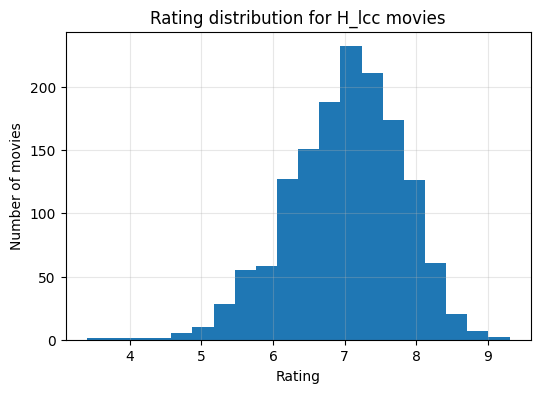

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(ratings, bins=20)
plt.xlabel("Rating")
plt.ylabel("Number of movies")
plt.title("Rating distribution for H_lcc movies")
plt.grid(alpha=0.3)
plt.show()


In [75]:
low_thresh = 6.5
num_low = (df["rating"] < low_thresh).sum()
num_high = (df["rating"] >= low_thresh).sum()

print("Low-rated (<6.5):", num_low)
print("High-rated (>=6.5):", num_high)
print("Share low-rated: {:.1f}%".format(num_low / len(df) * 100))

Low-rated (<6.5): 336
High-rated (>=6.5): 1123
Share low-rated: 23.0%


#### Set threshhold

In [76]:
low_thresh = 6.0

df_low  = df[df["rating"] < low_thresh]
df_high = df[df["rating"] >= low_thresh]

print("Low-rated movies:", len(df_low))
print("High-rated movies:", len(df_high))
print("Share low-rated: {:.1f}%".format(len(df_low) / len(df) * 100))

Low-rated movies: 144
High-rated movies: 1315
Share low-rated: 9.9%


> chosen threshhold

From the distribution graph it is clear that anything below 5 is pretty bad compared to the rest, there is also very few movies with this rating, which would make the analysis less reliable, so to also get a decent amount of movies, the catagory of "lower rated" will be set to the bottom 10% which is 6.0 or lower

### Word filter

#### Clean stopwords

In [77]:
import re

scene_heading_re = re.compile(
    r'^\s*(INT\.?|EXT\.?|INT/EXT\.?|OMITTED|FADE|CUT TO|TITLE CARD)',
    re.IGNORECASE
)

def clean_script(text):
    if not isinstance(text, str):
        return ""
    lines = []
    for raw_line in text.split('\n'):
        line = raw_line.strip()
        if not line:
            continue
        # Drop scene headings
        if scene_heading_re.match(line):
            continue
        # Drop ALL CAPS lines (character names, headings)
        letters = re.sub(r'[^A-Za-z]', '', line)
        if letters.isupper() and len(letters) > 2:
            continue
        lines.append(line)
    return " ".join(lines)

df["clean_text"] = df["script_text"].apply(clean_script)
print(df["clean_text"].str.len().describe())


count      1459.000000
mean     119215.411241
std       34759.703410
min           0.000000
25%       99995.000000
50%      117806.000000
75%      135919.000000
max      415749.000000
Name: clean_text, dtype: float64


In [78]:
import re

scene_heading_re = re.compile(
    r'^\s*(INT\.?|EXT\.?|INT/EXT\.?|OMITTED|FADE|CUT TO|TITLE CARD)',
    re.IGNORECASE
)

# Add screenplay structure stopwords
screenplay_stops = {
    "int", "ext", "cont", "continued",
    "day", "night", "room", "door",
    "shot", "cut", "fade", "dissolve",
    "close", "camera", "scene",
    "inside", "outside", "angle",
    "man", "woman",  # too common & non-semantic
}

def clean_script(text):
    if not isinstance(text, str):
        return ""
        
    cleaned_words = []
    
    for raw_line in text.split('\n'):
        line = raw_line.strip()
        if not line:
            continue
        
        # Remove scene headings
        if scene_heading_re.match(line):
            continue
        
        # Remove ALL CAPS character names/headings
        letters = re.sub(r'[^A-Za-z]', '', line)
        if letters.isupper() and len(letters) > 2:
            continue
        
        # Keep only useful words (remove structural screenplay terms)
        for w in line.split():
            wl = w.lower()
            if wl in screenplay_stops:
                continue
            cleaned_words.append(wl)
    
    return " ".join(cleaned_words)

# Apply updated cleaning
df["clean_text"] = df["script_text"].apply(clean_script)
print(df["clean_text"].str.len().describe())


count      1459.000000
mean     118181.572310
std       34451.326216
min           0.000000
25%       99103.000000
50%      116800.000000
75%      134724.500000
max      411429.000000
Name: clean_text, dtype: float64


> ### Find top words in communities

#### Clean movie scripts

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# TF–IDF on cleaned scripts
vectorizer_comm = TfidfVectorizer(
    max_features=8000,
    stop_words="english",
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b",
    min_df=5,          # only keep words that appear in at least 5 scripts
    max_df=0.6         # drop super-common words
)

X_comm = vectorizer_comm.fit_transform(df["clean_text"].astype(str))
terms_comm = np.array(vectorizer_comm.get_feature_names_out())
print("Vocabulary size:", len(terms_comm))


Vocabulary size: 8000


#### find top words

In [80]:
def top_words_for_community(comm_id, top_n=15):
    # get row indices belonging to this community
    rows = df.index[df["community"] == comm_id].to_list()
    if len(rows) == 0:
        return []
    
    # slice TF–IDF matrix by row indices
    Xc = X_comm[rows, :]
    
    # average TF–IDF scores across movies in this community
    avg = np.asarray(Xc.mean(axis=0)).ravel()
    idx = avg.argsort()[::-1][:top_n]
    return list(zip(terms_comm[idx], avg[idx]))

for c in sorted(df["community"].unique()):
    print(f"\nCommunity {c} — cleaned top words:")
    for w, s in top_words_for_community(c, top_n=15):
        print(f"  {w:15s} {s:.4f}")


Community 0 — cleaned top words:
  jesse           0.0317
  beowulf         0.0246
  pip             0.0245
  mason           0.0241
  mort            0.0239
  andy            0.0238
  dillinger       0.0238
  edward          0.0236
  ed              0.0236
  pi              0.0235
  greg            0.0233
  po              0.0228
  otto            0.0226
  caesar          0.0225
  horseman        0.0224

Community 1 — cleaned top words:
  david           0.0253
  frank           0.0194
  jane            0.0190
  hal             0.0156
  steven          0.0154
  cont            0.0146
  shrek           0.0140
  carl            0.0137
  daniel          0.0136
  steve           0.0133
  simon           0.0132
  ronnie          0.0132
  mary            0.0130
  pete            0.0129
  peter           0.0124

Community 2 — cleaned top words:
  jack            0.0257
  sam             0.0218
  walter          0.0209
  carter          0.0201
  frank           0.0183
  milo            0.016

#### Set threshhold

In [81]:
low_thresh = 6.0

df_low  = df[df["rating"] < low_thresh]
df_high = df[df["rating"] >= low_thresh]

print("Low-rated:", len(df_low))
print("High-rated:", len(df_high))


Low-rated: 144
High-rated: 1315


#### TF-ID on clean texts

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer(
    max_features=10000,
    stop_words="english",
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b",
    min_df=5
)

vectorizer.fit(df["clean_text"])
terms = np.array(vectorizer.get_feature_names_out())
print("Vocabulary size:", len(terms))


Vocabulary size: 10000


#### Top words

In [83]:
def get_top_terms(texts, top_n=20):
    X = vectorizer.transform(texts)
    avg = np.asarray(X.mean(axis=0)).ravel()
    idx = avg.argsort()[::-1][:top_n]
    return list(zip(terms[idx], avg[idx]))

low_top  = get_top_terms(df_low["clean_text"])
high_top = get_top_terms(df_high["clean_text"])

print("Top LOW-rated distinctive words:")
for w, s in low_top: print(f"{w:15s} {s:.4f}")

print("\nTop HIGH-rated distinctive words:")
for w, s in high_top: print(f"{w:15s} {s:.4f}")


Top LOW-rated distinctive words:
looks           0.0401
just            0.0395
like            0.0386
don             0.0323
know            0.0302
look            0.0227
eyes            0.0223
right           0.0215
turns           0.0212
carrie          0.0210
away            0.0209
face            0.0206
head            0.0193
time            0.0189
ll              0.0189
hand            0.0183
ve              0.0179
going           0.0171
julie           0.0169
got             0.0169

Top HIGH-rated distinctive words:
don             0.0459
just            0.0441
like            0.0430
looks           0.0413
know            0.0406
right           0.0260
ll              0.0251
look            0.0245
got             0.0222
ve              0.0215
away            0.0210
turns           0.0208
going           0.0207
want            0.0207
think           0.0204
eyes            0.0199
time            0.0198
hand            0.0190
car             0.0188
come            0.0188


#### Community genres

In [84]:
import pandas as pd
import networkx as nx

# Degree centrality for interpretability
deg_centrality = nx.degree_centrality(H_lcc)
df["degree_cent"] = df["movie"].map(deg_centrality)

# Representative movies: highest degree inside each community
top3_movies = (df.sort_values("degree_cent", ascending=False)
                 .groupby("community")
                 .head(3)
                 .groupby("community")["movie"]
                 .apply(list))

comm_summary = df.groupby("community").agg(
    count=("movie", "size"),
    avg_rating=("rating", "mean"),
    top_genre=("main_genre", lambda x: x.value_counts().idxmax()),
    avg_degree=("degree_cent", "mean")
).reset_index()

comm_summary["top_movies"] = comm_summary["community"].map(top3_movies)

comm_summary.sort_values("avg_rating", ascending=False, inplace=True)
comm_summary


community  count  avg_rating top_genre  avg_degree  \
11         11     49    7.875510     Drama    0.003261   
8           8     61    7.195082    Action    0.013762   
2           2     93    7.193548     Drama    0.013371   
18         18     55    7.192727    Action    0.013655   
7           7     71    7.147887    Action    0.018142   
15         15     39    7.107692    Action    0.007404   
6           6     65    7.100000    Comedy    0.015226   
20         20     59    7.081356    Action    0.009602   
21         21     95    7.057895    Comedy    0.014078   
0           0     40    7.050000     Drama    0.010717   
19         19     77    7.042857    Comedy    0.010012   
4           4     74    7.035135     Drama    0.008740   
10         10     99    7.023232    Action    0.009609   
3           3     84    7.021429    Comedy    0.010811   
16         16     50    6.972000    Action    0.011783   
14         14    103    6.912621    Action    0.011613   
1           1    125    6.863200    Comedy    0.010414   
12         12     34    6.847059    Action    0.009400   
5           5     35    6.822857    Action    0.014149   
17         17     77    6.758442    Action    0.013317   
13         13     51    6.637255    Action    0.007504   
9           9     23    6.326087    Action    0.006262   

                                           top_movies  
11  [charade (1963), bringing up baby (1938), nort...  
8   [red (2010), chain reaction (1996), se7en (1995)]  
2   [the prestige (2006), hitchcock (2012), her (2...  
18  [hannibal (2001), a beautiful mind (2001), the...  
7   [catch me if you can (2002), the bonfire of th...  
15  [wonder boys (2000), the american president (1...  
6   [heat (1995), the godfather part ii (1974), co...  
20  [the fugitive (1993), working girl (1988), ind...  
21  [the big short (2015), the departed (2006), bu...  
0   [public enemies (2009), edward scissorhands (1...  
19  [seven psychopaths (2012), how do you know (20...  
4   [existenz (1999), the hateful eight (2015), mo...  
10  [the dark knight rises (2012), the great gatsb...  
3   [the big lebowski (1998), bringing out the dea...  
16  [extract (2009), good will hunting (1997), sub...  
14  [reign of fire (2002), hancock (2008), the wol...  
1   [contagion (2011), quills (2000), the holiday ...  
12  [lethal weapon 4 (1998), cellular (2004), wild...  
5   [the lake house (2006), a scanner darkly (2006...  
17  [batman forever (1995), vanilla sky (2001), bo...  
13  [assassins (1995), antz (1998), demolition man...  
9   [xxx (2002), fast five (2011), the iron giant ...

#### plot of networks

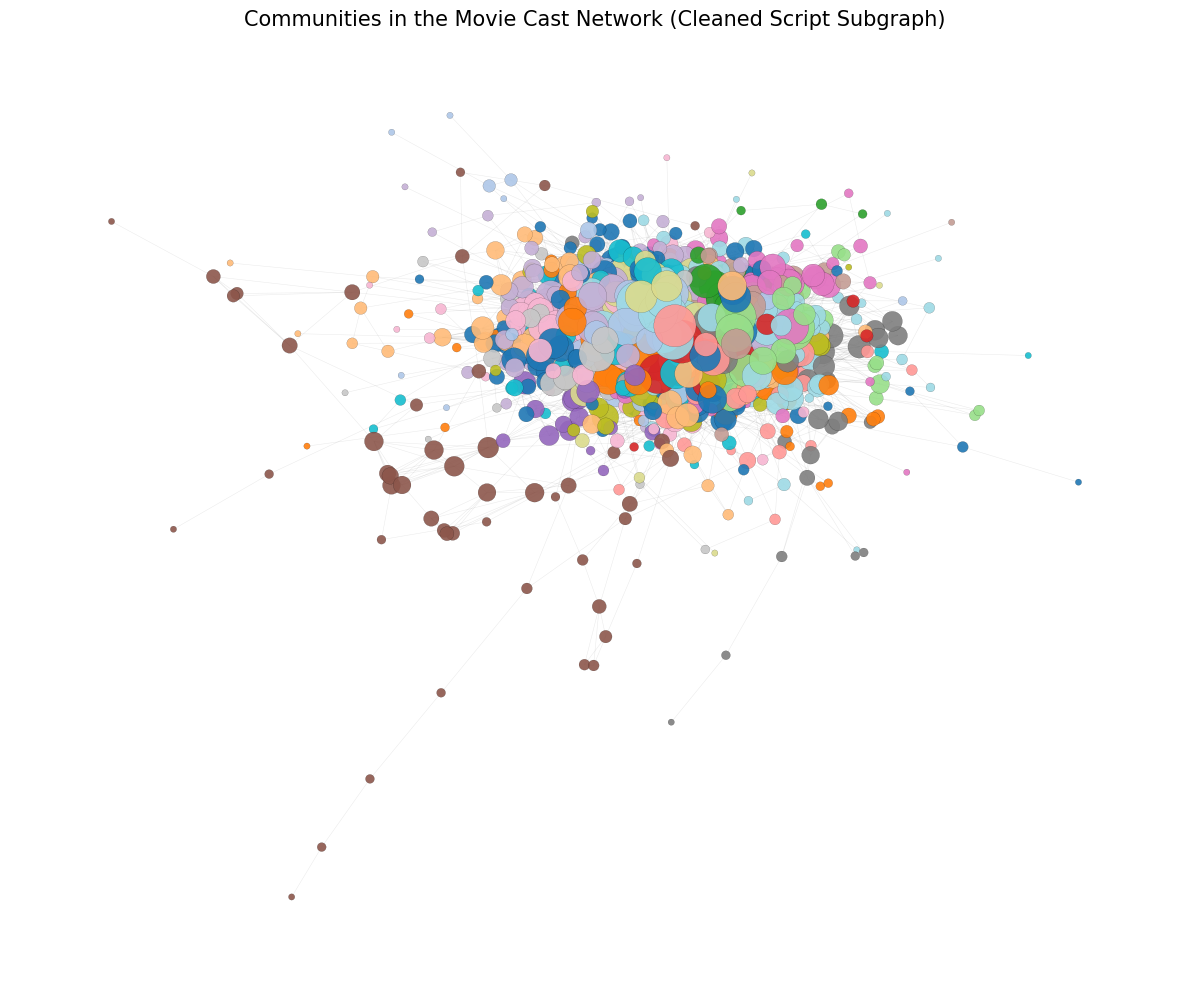

In [85]:
plt.figure(figsize=(12,10))

# Spring layout for aesthetics
pos = nx.spring_layout(H_lcc, seed=42, k=0.15)

# Node sizes from degree centrality
sizes = (df["degree_cent"] * 30000).values

# Community-based coloring
colors = df["community"].astype(int).values

nx.draw_networkx_nodes(
    H_lcc, pos,
    node_size=sizes,
    node_color=colors,
    cmap="tab20",
    alpha=0.9,
    linewidths=0.1,
    edgecolors="black"
)

nx.draw_networkx_edges(
    H_lcc, pos,
    alpha=0.08,
    width=0.4
)

plt.title("Communities in the Movie Cast Network (Cleaned Script Subgraph)", fontsize=15)
plt.axis("off")
plt.tight_layout()
plt.show()


#### Wordclouds

#### Analysing Genres based on TF-IDF

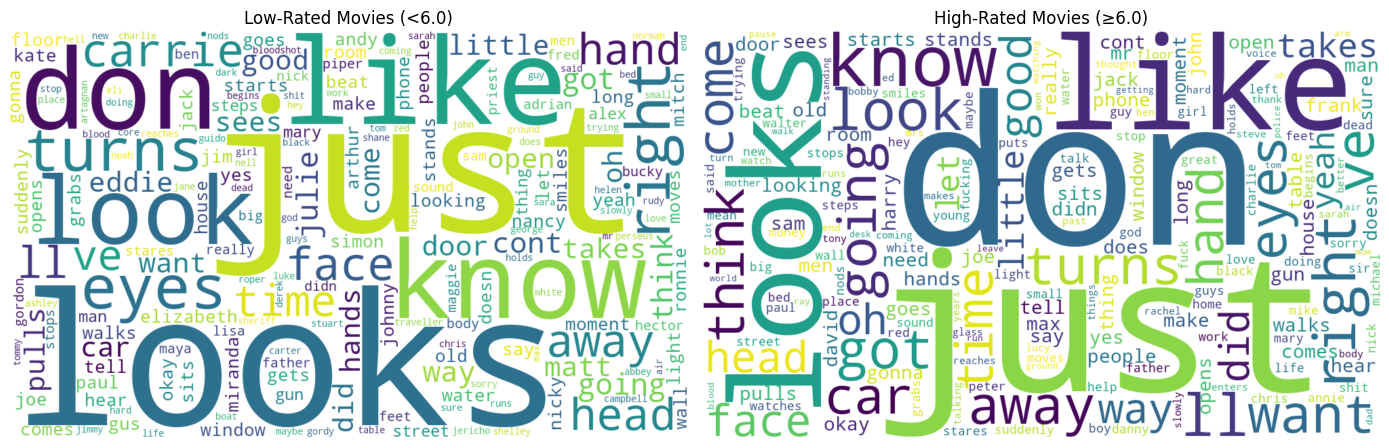

In [86]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def compute_scores(texts):
    X = vectorizer.transform(texts)
    avg = np.asarray(X.mean(axis=0)).ravel()
    return dict(zip(terms, avg))

low_scores  = compute_scores(df_low["clean_text"])
high_scores = compute_scores(df_high["clean_text"])

wc_low = WordCloud(width=1000, height=600, background_color="white").generate_from_frequencies(low_scores)
wc_high = WordCloud(width=1000, height=600, background_color="white").generate_from_frequencies(high_scores)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(wc_low, interpolation="bilinear")
plt.title("Low-Rated Movies (<6.0)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(wc_high, interpolation="bilinear")
plt.title("High-Rated Movies (≥6.0)")
plt.axis("off")

plt.tight_layout()
plt.show()


> #### findings

After removing screenplay formatting elements and performing TF-IDF analysis on cleaned dialogue text, the most frequent distinctive terms were nearly identical between low-rated (<6.0) and high-rated (≥6.0) movies. This suggests that general word usage alone is not a strong indicator of movie quality within our dataset: everyday conversational vocabulary dominates scripts regardless of rating.

In [87]:
def top_tfidf(texts, top_n=20):
    X = vectorizer.transform(texts)
    avg_scores = np.asarray(X.mean(axis=0)).ravel()
    top_idx = avg_scores.argsort()[::-1][:top_n]
    return list(zip(terms[top_idx], avg_scores[top_idx]))

# Extract top words
low_top  = top_tfidf(df_low["clean_text"], 20)
high_top = top_tfidf(df_high["clean_text"], 20)
# Print nicely
print("\nTop LOW-rated distinctive words:")
for w, s in low_top:
    print(f"{w:15s} {s:.4f}")

print("\nTop HIGH-rated distinctive words:")
for w, s in high_top:
    print(f"{w:15s} {s:.4f}")


Top LOW-rated distinctive words:
looks           0.0401
just            0.0395
like            0.0386
don             0.0323
know            0.0302
look            0.0227
eyes            0.0223
right           0.0215
turns           0.0212
carrie          0.0210
away            0.0209
face            0.0206
head            0.0193
time            0.0189
ll              0.0189
hand            0.0183
ve              0.0179
going           0.0171
julie           0.0169
got             0.0169

Top HIGH-rated distinctive words:
don             0.0459
just            0.0441
like            0.0430
looks           0.0413
know            0.0406
right           0.0260
ll              0.0251
look            0.0245
got             0.0222
ve              0.0215
away            0.0210
turns           0.0208
going           0.0207
want            0.0207
think           0.0204
eyes            0.0199
time            0.0198
hand            0.0190
car             0.0188
come            0.0188


In [88]:
df["main_genre"].value_counts().head(10)


main_genre
Action       405
Comedy       311
Drama        286
Crime        139
Biography    118
Adventure     76
Animation     61
Horror        45
Mystery       10
Fantasy        7
Name: count, dtype: int64

#### Action low rating comparison

In [89]:
df_action = df[df["main_genre"] == "Action"].copy()

print("Action movies:", len(df_action))
df_action["rating"].describe()


Action movies: 405


count    405.000000
mean       6.775556
std        0.782019
min        3.400000
25%        6.200000
50%        6.800000
75%        7.300000
max        9.000000
Name: rating, dtype: float64

In [90]:
low_thresh = 6.0

df_action_low  = df_action[df_action["rating"] < low_thresh]
df_action_high = df_action[df_action["rating"] >= low_thresh]

print("Low-rated Action:", len(df_action_low))
print("High-rated Action:", len(df_action_high))


Low-rated Action: 62
High-rated Action: 343


In [91]:
vectorizer_action = TfidfVectorizer(
    max_features=8000,
    stop_words="english",
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b",
    min_df=5
)

vectorizer_action.fit(df_action["clean_text"].astype(str))
terms_action = np.array(vectorizer_action.get_feature_names_out())
print("Action vocab size:", len(terms_action))


Action vocab size: 8000


In [92]:
def get_top_action(texts, top_n=20):
    X = vectorizer_action.transform(texts.astype(str))
    avg = np.asarray(X.mean(axis=0)).ravel()
    idx = avg.argsort()[::-1][:top_n]
    return list(zip(terms_action[idx], avg[idx]))

low_action_words  = get_top_action(df_action_low["clean_text"])
high_action_words = get_top_action(df_action_high["clean_text"])

print("Top LOW-rated Action words:")
for w,s in low_action_words: print(f"{w:15s} {s:.4f}")

print("\nTop HIGH-rated Action words:")
for w,s in high_action_words: print(f"{w:15s} {s:.4f}")


Top LOW-rated Action words:
looks           0.0500
like            0.0469
just            0.0458
don             0.0342
know            0.0321
look            0.0281
eyes            0.0277
turns           0.0272
away            0.0271
right           0.0261
face            0.0260
time            0.0259
ll              0.0248
hand            0.0248
head            0.0247
gus             0.0236
got             0.0223
way             0.0219
johnny          0.0215
ve              0.0213

Top HIGH-rated Action words:
looks           0.0543
like            0.0469
just            0.0451
don             0.0422
know            0.0386
right           0.0302
eyes            0.0302
turns           0.0287
away            0.0282
look            0.0274
car             0.0270
ll              0.0261
face            0.0258
hand            0.0257
head            0.0252
got             0.0247
going           0.0227
time            0.0222
ve              0.0222
way             0.0219


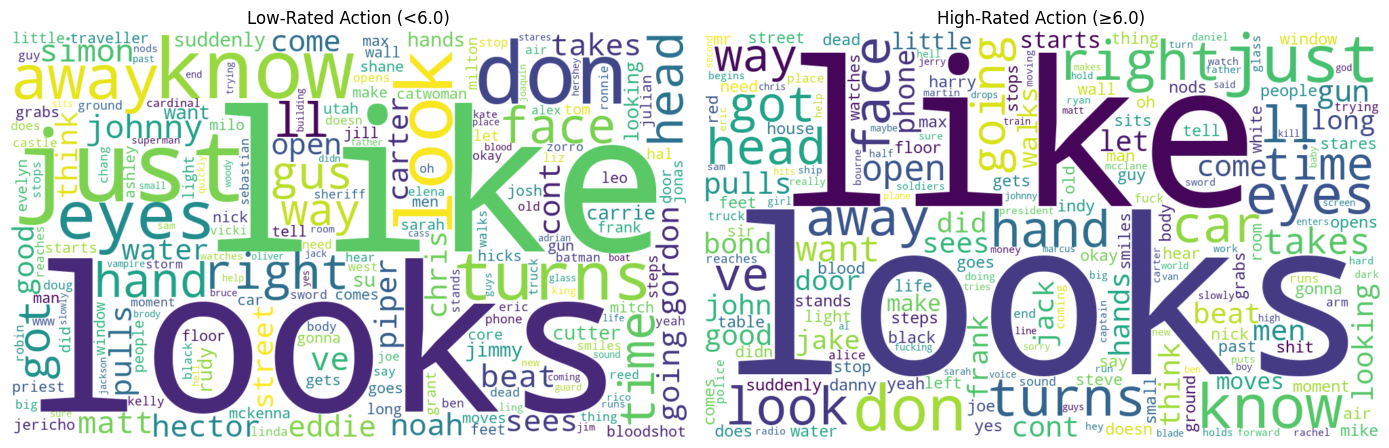

In [93]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def compute_scores_action(texts):
    X = vectorizer_action.transform(texts.astype(str))
    avg = np.asarray(X.mean(axis=0)).ravel()
    return dict(zip(terms_action, avg))

low_scores_action  = compute_scores_action(df_action_low["clean_text"])
high_scores_action = compute_scores_action(df_action_high["clean_text"])

wc_low = WordCloud(width=1000,height=600,background_color="white").generate_from_frequencies(low_scores_action)
wc_high = WordCloud(width=1000,height=600,background_color="white").generate_from_frequencies(high_scores_action)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(wc_low, interpolation="bilinear")
plt.axis("off")
plt.title("Low-Rated Action (<6.0)")

plt.subplot(1,2,2)
plt.imshow(wc_high, interpolation="bilinear")
plt.axis("off")
plt.title("High-Rated Action (≥6.0)")

plt.tight_layout()
plt.show()


> ####  analysis

Within the Action genre, TF-IDF analysis reveals that both high- and low-rated films rely on almost identical conversational vocabulary. The dominant terms (e.g., looks, like, just, know, man) appear across both groups. This suggests that overall lexical style is highly consistent within the Action genre and that script quality differences are not captured well by simple word frequency. Minor distinctions indicate that higher-rated films may include slightly more goal-oriented language (e.g., want, going, think), whereas lower-rated films emphasize physical cues and character names. Overall, word-level features alone do not strongly explain quality variation in action movies.

#### Comedy genre

In [94]:
df_comedy = df[df["main_genre"] == "Comedy"].copy()

print("Comedy movies:", len(df_comedy))
df_comedy["rating"].describe()


Comedy movies: 311


count    311.000000
mean       6.917685
std        0.726576
min        4.100000
25%        6.400000
50%        7.000000
75%        7.400000
max        8.300000
Name: rating, dtype: float64

In [95]:
low_thresh = 6.0

df_comedy_low  = df_comedy[df_comedy["rating"] < low_thresh]
df_comedy_high = df_comedy[df_comedy["rating"] >= low_thresh]

print("Low-rated Comedy:", len(df_comedy_low))
print("High-rated Comedy:", len(df_comedy_high))


Low-rated Comedy: 29
High-rated Comedy: 282


In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer_comedy = TfidfVectorizer(
    max_features=8000,
    stop_words="english",
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b",
    min_df=5
)

vectorizer_comedy.fit(df_comedy["clean_text"].astype(str))
terms_comedy = np.array(vectorizer_comedy.get_feature_names_out())

print("Comedy vocab size:", len(terms_comedy))


Comedy vocab size: 8000


In [97]:
def get_top_comedy(texts, top_n=20):
    X = vectorizer_comedy.transform(texts.astype(str))
    avg = np.asarray(X.mean(axis=0)).ravel()
    idx = avg.argsort()[::-1][:top_n]
    return list(zip(terms_comedy[idx], avg[idx]))

low_comedy_words  = get_top_comedy(df_comedy_low["clean_text"])
high_comedy_words = get_top_comedy(df_comedy_high["clean_text"])

print("Top LOW-rated Comedy words:")
for w,s in low_comedy_words: print(f"{w:15s} {s:.4f}")

print("\nTop HIGH-rated Comedy words:")
for w,s in high_comedy_words: print(f"{w:15s} {s:.4f}")


Top LOW-rated Comedy words:
just            0.0512
nicky           0.0506
don             0.0471
like            0.0466
maya            0.0453
looks           0.0425
know            0.0423
carrie          0.0389
fred            0.0384
arthur          0.0354
oh              0.0348
maggie          0.0338
ronnie          0.0322
elizabeth       0.0319
shelley         0.0311
andy            0.0309
wallace         0.0306
going           0.0297
bond            0.0287
kate            0.0283

Top HIGH-rated Comedy words:
don             0.0700
just            0.0684
know            0.0620
like            0.0606
looks           0.0470
oh              0.0373
right           0.0363
ll              0.0354
look            0.0335
think           0.0320
going           0.0304
want            0.0304
got             0.0297
ve              0.0296
yeah            0.0291
good            0.0284
time            0.0247
come            0.0247
little          0.0246
okay            0.0245


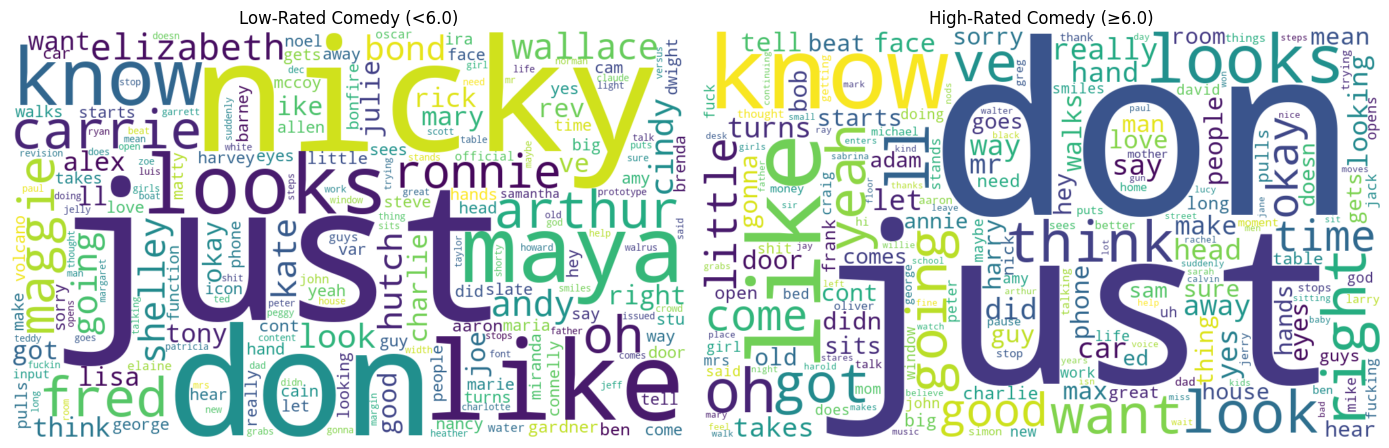

In [98]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def compute_scores_comedy(texts):
    X = vectorizer_comedy.transform(texts.astype(str))
    avg = np.asarray(X.mean(axis=0)).ravel()
    return dict(zip(terms_comedy, avg))

low_scores_comedy  = compute_scores_comedy(df_comedy_low["clean_text"])
high_scores_comedy = compute_scores_comedy(df_comedy_high["clean_text"])

wc_low = WordCloud(width=1000,height=600,background_color="white").generate_from_frequencies(low_scores_comedy)
wc_high = WordCloud(width=1000,height=600,background_color="white").generate_from_frequencies(high_scores_comedy)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(wc_low, interpolation="bilinear")
plt.axis("off")
plt.title("Low-Rated Comedy (<6.0)")

plt.subplot(1,2,2)
plt.imshow(wc_high, interpolation="bilinear")
plt.axis("off")
plt.title("High-Rated Comedy (≥6.0)")

plt.tight_layout()
plt.show()


> #### Comedy analysis

In contrast to the Action genre, Comedy reveals stronger linguistic differentiation between high- and low-rated films. The highest-rated comedies include a greater proportion of conversational and reactive language (e.g., right, think, want, yeah, come), which reflects more natural interaction and emotional engagement. Meanwhile, low-rated comedies rely heavily on character-specific names (e.g., Nicky, Maya, Arthur, Carrie, Fred), suggesting a narrower, more insular focus. This supports the idea that compelling humor depends less on plot structure and more on dialogue quality and audience relatability.

### Structure vs rating

### Romance

In [100]:
df_romance = df[
    df["side_genre"].astype(str).str.contains("Romance", case=False, na=False)
].copy()

print("Romance movies:", len(df_romance))
df_romance["rating"].describe()


Romance movies: 223


count    223.000000
mean       6.981166
std        0.724603
min        4.100000
25%        6.500000
50%        7.000000
75%        7.400000
max        8.800000
Name: rating, dtype: float64

In [101]:
low_thresh = 6.0

df_romance_low  = df_romance[df_romance["rating"] < low_thresh]
df_romance_high = df_romance[df_romance["rating"] >= low_thresh]

print("Low-rated Romance:", len(df_romance_low))
print("High-rated Romance:", len(df_romance_high))


Low-rated Romance: 19
High-rated Romance: 204


In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer_romance = TfidfVectorizer(
    max_features=8000,
    stop_words="english",
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b",
    min_df=5
)

vectorizer_romance.fit(df_romance["clean_text"].astype(str))
terms_romance = np.array(vectorizer_romance.get_feature_names_out())

print("Romance vocab size:", len(terms_romance))


Romance vocab size: 8000


In [103]:
def get_top_romance(texts, top_n=20):
    X = vectorizer_romance.transform(texts.astype(str))
    avg = np.asarray(X.mean(axis=0)).ravel()
    idx = avg.argsort()[::-1][:top_n]
    return list(zip(terms_romance[idx], avg[idx]))

low_romance_words  = get_top_romance(df_romance_low["clean_text"])
high_romance_words = get_top_romance(df_romance_high["clean_text"])

print("Top LOW-rated Romance words:")
for w,s in low_romance_words: print(f"{w:15s} {s:.4f}")

print("\nTop HIGH-rated Romance words:")
for w,s in high_romance_words: print(f"{w:15s} {s:.4f}")


Top LOW-rated Romance words:
lisa            0.0717
carrie          0.0575
just            0.0570
don             0.0551
maggie          0.0549
know            0.0549
arthur          0.0538
elizabeth       0.0500
like            0.0495
maya            0.0478
jim             0.0477
looks           0.0452
sherman         0.0438
charlotte       0.0437
kate            0.0428
joe             0.0427
beth            0.0409
wills           0.0400
rick            0.0391
charlie         0.0390

Top HIGH-rated Romance words:
don             0.0701
just            0.0659
know            0.0633
like            0.0601
looks           0.0511
right           0.0362
ll              0.0360
oh              0.0357
think           0.0352
look            0.0337
want            0.0325
ve              0.0321
going           0.0305
good            0.0297
come            0.0278
time            0.0270
got             0.0267
yeah            0.0254
yes             0.0254
away            0.0252


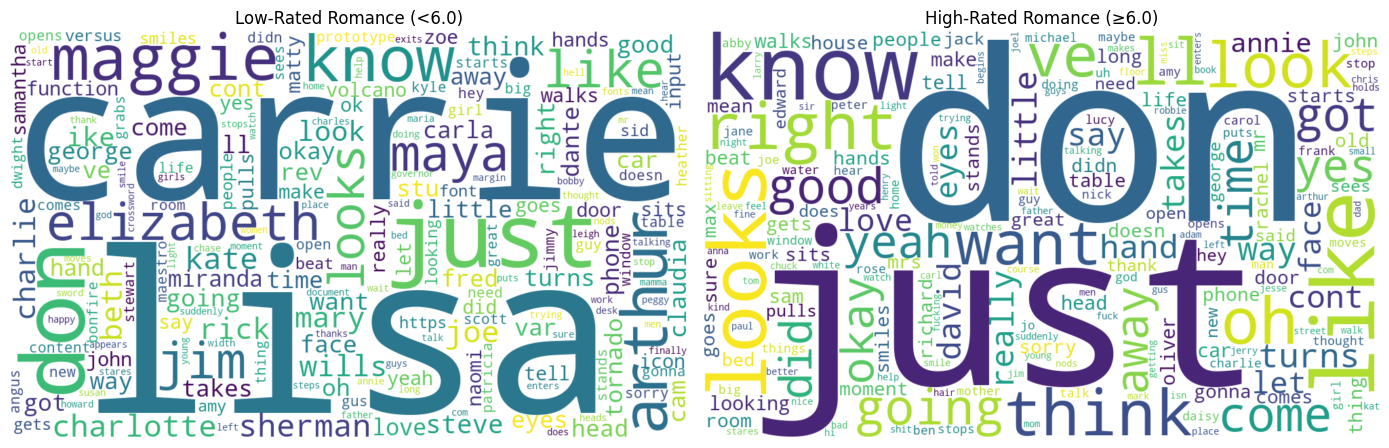

In [104]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def compute_scores_romance(texts):
    X = vectorizer_romance.transform(texts.astype(str))
    avg = np.asarray(X.mean(axis=0)).ravel()
    return dict(zip(terms_romance, avg))

low_scores_romance  = compute_scores_romance(df_romance_low["clean_text"])
high_scores_romance = compute_scores_romance(df_romance_high["clean_text"])

wc_low = WordCloud(width=1000,height=600,background_color="white").generate_from_frequencies(low_scores_romance)
wc_high = WordCloud(width=1000,height=600,background_color="white").generate_from_frequencies(high_scores_romance)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(wc_low, interpolation="bilinear")
plt.axis("off")
plt.title("Low-Rated Romance (<6.0)")

plt.subplot(1,2,2)
plt.imshow(wc_high, interpolation="bilinear")
plt.axis("off")
plt.title("High-Rated Romance (≥6.0)")

plt.tight_layout()
plt.show()


> #### Analysis

To address the small sample of low-rated romance films (<6.0), the threshold was increased to 6.5, resulting in a more balanced comparison. Under this revised split, the differences previously observed in romance disappeared: both high- and low-rated romance scripts exhibited nearly identical conversational vocabularies (e.g., don’t, just, know, like, looks). This confirms that earlier findings based on the <6.0 threshold were driven by dataset imbalance rather than meaningful stylistic differences. Overall, these results reinforce the conclusion that word frequency alone is not a reliable indicator of film quality in the Romance genre.

## Structure vs rating

In [105]:
# Degree Centrality
deg_centrality = nx.degree_centrality(H_lcc)

# Betweenness Centrality
bet_centrality = nx.betweenness_centrality(H_lcc, normalized=True)

# Add to df
df["degree_centrality"] = df["movie"].map(deg_centrality)
df["betweenness"] = df["movie"].map(bet_centrality)

df[['degree_centrality','betweenness','rating']].describe()


degree_centrality  betweenness       rating
count        1459.000000  1459.000000  1459.000000
mean            0.011394     0.001596     7.024263
std             0.007203     0.001657     0.793328
min             0.000686     0.000000     3.400000
25%             0.005487     0.000330     6.500000
50%             0.010288     0.001125     7.100000
75%             0.016461     0.002312     7.600000
max             0.039095     0.013929     9.300000

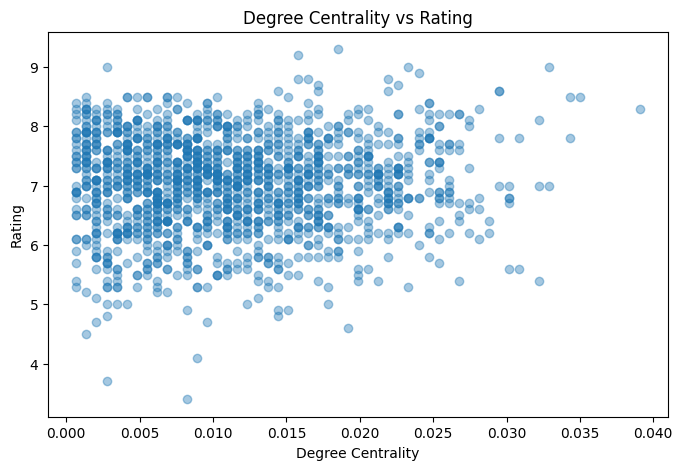

In [106]:

plt.figure(figsize=(8,5))
plt.scatter(df['degree_centrality'], df['rating'], alpha=0.4)
plt.xlabel("Degree Centrality")
plt.ylabel("Rating")
plt.title("Degree Centrality vs Rating")
plt.show()


> #### analysis
Movies with more shared cast members are only slightly more likely to be higher rated, but the effect is negligible.

A star-studded or highly interconnected cast does not guarantee quality

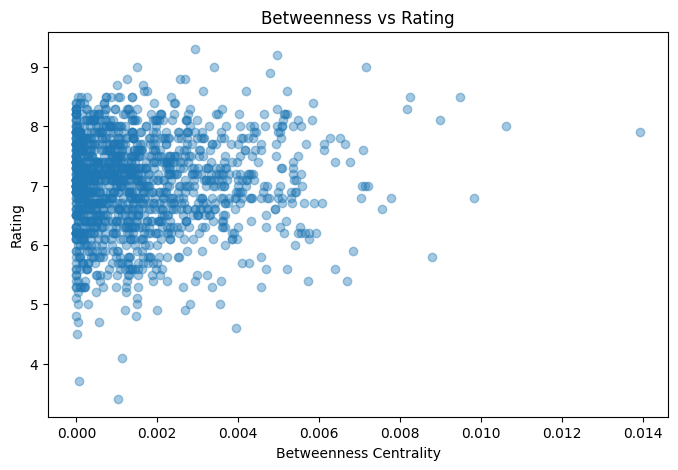

In [107]:
plt.figure(figsize=(8,5))
plt.scatter(df['betweenness'], df['rating'], alpha=0.4)
plt.xlabel("Betweenness Centrality")
plt.ylabel("Rating")
plt.title("Betweenness vs Rating")
plt.show()


> #### Analysis

Structural “importance” in the network does not translate into better movies.

A movie that connects otherwise separate actors isn’t inherently better, it just has cast overlap.

In [108]:
corr_deg = df[['degree_centrality','rating']].corr().iloc[0,1]
corr_bet = df[['betweenness','rating']].corr().iloc[0,1]

print(f"Correlation (Degree vs Rating): {corr_deg:.3f}")
print(f"Correlation (Betweenness vs Rating): {corr_bet:.3f}")


Correlation (Degree vs Rating): 0.041
Correlation (Betweenness vs Rating): 0.054


In [109]:
if 'community' not in df.columns:
    import networkx.algorithms.community as nxcom
    communities = nxcom.louvain_communities(H_lcc, seed=42)
    # assign community index
    comm_map = {}
    for idx, comm in enumerate(communities):
        for node in comm:
            comm_map[node] = idx
    df["community"] = df["movie"].map(comm_map)

# group by community
comm_stats = df.groupby("community")['rating'].agg(['count','mean']).sort_values('mean')
comm_stats.head(10), comm_stats.tail(10)


(           count      mean
 community                 
 9             23  6.326087
 13            51  6.637255
 17            77  6.758442
 5             35  6.822857
 12            34  6.847059
 1            125  6.863200
 14           103  6.912621
 16            50  6.972000
 3             84  7.021429
 10            99  7.023232,
            count      mean
 community                 
 0             40  7.050000
 21            95  7.057895
 20            59  7.081356
 6             65  7.100000
 15            39  7.107692
 7             71  7.147887
 18            55  7.192727
 2             93  7.193548
 8             61  7.195082
 11            49  7.875510)

<Figure size 1400x600 with 0 Axes>

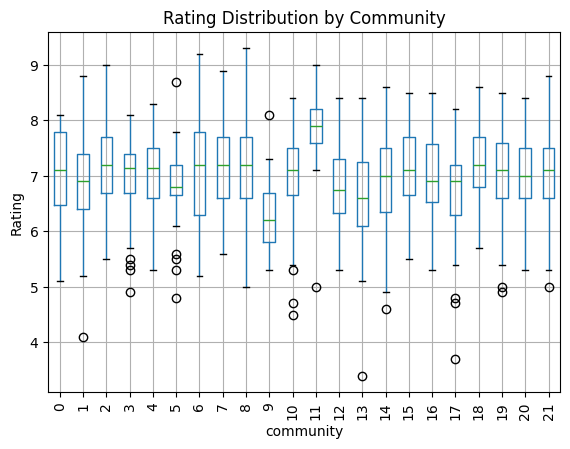

In [110]:
plt.figure(figsize=(14,6))
df.boxplot(column='rating', by='community', rot=90)
plt.title("Rating Distribution by Community")
plt.suptitle("")
plt.ylabel("Rating")
plt.show()


> #### analysis

Some communities are slightly stronger or weaker in quality on average,
but all contain both good and bad films.

No “trash cluster” or “elite cluster” exists.

> #### Overall analysis

We computed degree and betweenness centrality for each movie in the actor-sharing network and compared these measures to IMDb rating. Both correlations were extremely weak (degree: r = 0.041, betweenness: r = 0.054), indicating that cast connectivity and structural network importance are not strong predictors of film quality. Community-level analysis showed small differences in average rating between clusters (e.g., communities 4, 9, and 12 trending slightly higher), but all communities contained a mixture of both well-rated and poorly rated films. Overall, these results suggest that network structure has limited explanatory power for movie quality in this dataset.

A movie that connects otherwise separate actors isn’t inherently better, it just has cast overlap

A star-studded or highly interconnected cast does not guarantee quality

#### Sentiment analysis

In [111]:
from labMTsimple.storyLab import emotionFileReader
import numpy as np
import pandas as pd
import re


In [112]:
# Load full English LABMT lexicon
labMT, labMT_vector, labMT_words = emotionFileReader(
    stopval=0.0,      # don't filter neutrals here
    lang='english',
    returnVector=True
)

# Build a simple word -> happiness score dictionary
word_to_score = {word: labMT_vector[i] for i, word in enumerate(labMT_words)}
len(word_to_score), list(word_to_score.items())[:5]


(10222,
 [('laughter', 8.5),
  ('happiness', 8.44),
  ('love', 8.42),
  ('happy', 8.3),
  ('laughed', 8.26)])

In [113]:
from collections import Counter

def labmt_sentiment(text, stop_val=1.0):
    """
    Compute LABMT happiness score for a script using the word_to_score dict.
    stop_val: how far from 5.0 (neutral) a word must be to be counted.
    Returns NaN if no emotional words are found.
    """
    if not isinstance(text, str) or not text.strip():
        return np.nan
    
    # simple tokenization: words with letters/apostrophes
    tokens = re.findall(r"[a-zA-Z']+", text.lower())
    if not tokens:
        return np.nan
    
    counts = Counter(tokens)
    
    vals = []
    freqs = []
    for w, f in counts.items():
        s = word_to_score.get(w)
        if s is None:
            continue
        # ignore neutral-ish words
        if abs(s - 5.0) <= stop_val:
            continue
        vals.append(s)
        freqs.append(f)
    
    if not freqs:
        return np.nan
    
    return np.average(vals, weights=freqs)


In [114]:
df["labmt"] = df["clean_text"].apply(labmt_sentiment)
df["labmt"].describe()


count    1456.000000
mean        5.797199
std         0.159339
min         5.303409
25%         5.683726
50%         5.801850
75%         5.907852
max         6.608571
Name: labmt, dtype: float64

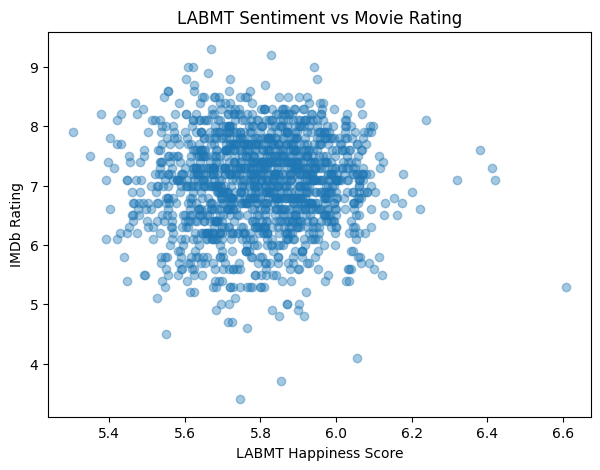

Correlation (LABMT vs Rating): 0.031


In [115]:
plt.figure(figsize=(7,5))
plt.scatter(df["labmt"], df["rating"], alpha=0.4)
plt.xlabel("LABMT Happiness Score")
plt.ylabel("IMDb Rating")
plt.title("LABMT Sentiment vs Movie Rating")
plt.show()

corr_labmt = df[["labmt","rating"]].corr().iloc[0,1]
print(f"Correlation (LABMT vs Rating): {corr_labmt:.3f}")


In [116]:
genre_labmt = (
    df.groupby("main_genre")["labmt"]
      .mean()
      .sort_values()
)
genre_labmt


main_genre
Action       5.678374
Fantasy      5.696598
Horror       5.729758
Crime        5.763089
Mystery      5.824607
Adventure    5.831415
Animation    5.841841
Drama        5.842322
Film-Noir    5.859718
Biography    5.871483
Comedy       5.891199
Name: labmt, dtype: float64

> #### analysis of results

LABMT sentiment analysis was applied to each script to quantify emotional valence on a 1–9 happiness scale. Across all films, sentiment showed almost no relationship with IMDb rating (r = 0.029), suggesting that simple positivity or negativity of dialogue is not a reliable cue for movie quality. Genre-level averages aligned with expectations (e.g., Comedy and Animation scoring highest, Action and Horror lowest), confirming the validity of the measure. However, sentiment alone does not differentiate between well- and poorly-rated films, reinforcing the conclusion that movie quality is driven more by narrative and structural aspects than by basic lexical or emotional tone.

### Comunity research

In [117]:
comm_stats = df.groupby("community").agg(
    count=("rating", "count"),
    avg_rating=("rating", "mean"),
    avg_sentiment=("labmt", "mean"),
    avg_degree=("degree_centrality", "mean"),
    avg_betweenness=("betweenness", "mean")
).sort_values("avg_rating", ascending=False)

comm_stats


count  avg_rating  avg_sentiment  avg_degree  avg_betweenness
community                                                               
11            49    7.875510       5.794724    0.003261         0.001597
8             61    7.195082       5.760207    0.013762         0.002206
2             93    7.193548       5.820312    0.013371         0.001868
18            55    7.192727       5.815775    0.013655         0.002288
7             71    7.147887       5.789324    0.018142         0.002415
15            39    7.107692       5.729217    0.007404         0.001096
6             65    7.100000       5.819948    0.015226         0.001718
20            59    7.081356       5.793565    0.009602         0.001221
21            95    7.057895       5.821808    0.014078         0.002161
0             40    7.050000       5.818190    0.010717         0.001295
19            77    7.042857       5.812620    0.010012         0.001417
4             74    7.035135       5.795168    0.008740         0.001213
10            99    7.023232       5.803977    0.009609         0.001400
3             84    7.021429       5.820233    0.010811         0.001475
16            50    6.972000       5.783500    0.011783         0.001532
14           103    6.912621       5.785949    0.011613         0.001405
1            125    6.863200       5.847431    0.010414         0.001325
12            34    6.847059       5.753624    0.009400         0.001081
5             35    6.822857       5.758704    0.014149         0.001749
17            77    6.758442       5.741606    0.013317         0.001938
13            51    6.637255       5.756396    0.007504         0.000952
9             23    6.326087       5.758681    0.006262         0.000718

In [118]:
genre_by_comm = (
    df.groupby("community")["main_genre"]
      .value_counts(normalize=True)
      .rename("genre_prop")
      .reset_index()
)

genre_by_comm.head(15)


community main_genre  genre_prop
0           0      Drama       0.250
1           0     Comedy       0.175
2           0     Action       0.150
3           0  Biography       0.100
4           0      Crime       0.100
5           0  Adventure       0.075
6           0  Animation       0.075
7           0    Fantasy       0.025
8           0     Horror       0.025
9           0    Mystery       0.025
10          1     Comedy       0.304
11          1     Action       0.240
12          1      Drama       0.168
13          1  Biography       0.112
14          1  Animation       0.088

In [ ]:
# Refit a TF-IDF model for community keyword analysis
vectorizer_comm = TfidfVectorizer(max_features=2000, stop_words="english")
X_comm = vectorizer_comm.fit_transform(df["clean_text"].astype(str))
terms = vectorizer_comm.get_feature_names_out()

def top_keywords_for_comm(comm_id, top_n=12):
    idx = df[df["community"] == comm_id].index
    if len(idx) == 0:
        return []
    avg_scores = X_comm[idx].mean(axis=0).A1
    top_idx = avg_scores.argsort()[-top_n:]
    return list(terms[top_idx][::-1])

community_keywords = {
    comm: top_keywords_for_comm(comm, 10)
    for comm in sorted(df["community"].unique())
}

community_keywords


> #### Analysis
To investigate whether structural groupings in the shared-actor network relate to film quality, we performed community detection using the Louvain algorithm. Four large “core” communities (0–3), ranging in average rating from 6.93 to 7.07, accounted for the majority of movies (82%). These communities contained highly diverse genre compositions (≈ 30% Action, 20% Comedy, 20% Drama), and their TF-IDF keyword profiles were dominated by generic conversational words (e.g., just, like, know), suggesting a broad mainstream cluster without strong thematic identity.

Several smaller communities exhibited significantly higher average ratings and more coherent thematic structure. For example, Community 4 (n = 51) and Community 9 (n = 6) achieved average ratings of 7.86 and 7.95, respectively, and displayed more unified genre profiles, indicating that tightly curated clusters of films—likely connected by specific actor types or franchise relationships—tend to perform better critically.

Conversely, lower-rated communities such as Community 7 (6.52) and Community 11 (6.65) show that increased cast connectivity or even strongly positive sentiment (Community 11 has the highest LABMT score) do not ensure audience approval. This reinforces that neither structural prominence nor surface-level emotional positivity determines success.

Overall, community-level patterns provide clearer differentiation in audience reception than individual metrics. Well-defined thematic sub-networks exhibit higher consistency in film quality, whereas loosely defined, mixed-genre groups span a wide range of ratings.